In [9]:
import pandas as pd
import os
import pickle
import statistics
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
from statsmodels.stats.weightstats import ztest as ztest
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load data

In [10]:
# read files
filepath = "./data/train/"
patients_dict = {}
for filename in os.listdir(filepath):
    if filename.endswith(".psv"):
        with open(filepath + filename) as openfile:
            patient = filename.split("_")[1]
            patient = patient.split(".")[0]
            df = pd.read_csv(openfile,sep="|")
            patients_dict[patient] = df
            

In [11]:
#create input for testing the model
processed_patients_dict = {}
patients_list = []
for k,v in patients_dict.items():
    for index, row in v.iterrows():
        if row['SepsisLabel'] == 1:
            processed_patients_dict[k] = v[:index+1]
            processed_patients_dict[k]['SepsisLabel'] = 1
            processed_patients_dict[k]['patient_id'] = k
            patients_list.append(processed_patients_dict[k])
            break
    if k not in processed_patients_dict.keys():
        processed_patients_dict[k] = v
        processed_patients_dict[k]['patient_id'] = k
        patients_list.append(processed_patients_dict[k])


<ipython-input-11-dcd0d96edad4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_patients_dict[k]['SepsisLabel'] = 1
<ipython-input-11-dcd0d96edad4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_patients_dict[k]['patient_id'] = k


In [12]:
df = pd.concat(patients_list, axis=0, ignore_index=True)

# Exploratory Data Analysis

## Features in the dataset:

In [13]:
# vital signal features
vitals = ['HR','O2Sat','Temp','SBP','MAP','DBP','Resp','EtCO2']

# lab test features
labs = ['BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2','AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate',
      'Magnesium','Phosphate','Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen','Platelets']

# demographic features
demogs = ['Age','Gender','Unit1','Unit2','HospAdmTime','ICULOS']

# labels
labels = ['SepsisLabel']

## Data exploration

In [14]:
ill_patients_dict = {}
not_ill_patients_dict = {}
for k,v in patients_dict.items():
    for index, row in v.iterrows():
        if row['SepsisLabel'] == 1:
            ill_patients_dict[k] = v
            break
    if k not in ill_patients_dict.keys():
        not_ill_patients_dict[k] = v

In [15]:
count_ill_patients = len(ill_patients_dict)
count_not_ill_patients = len(not_ill_patients_dict)
print("the percentage of ill patients is : ", count_ill_patients/(count_ill_patients+count_not_ill_patients))

the percentage of ill patients is :  0.07075


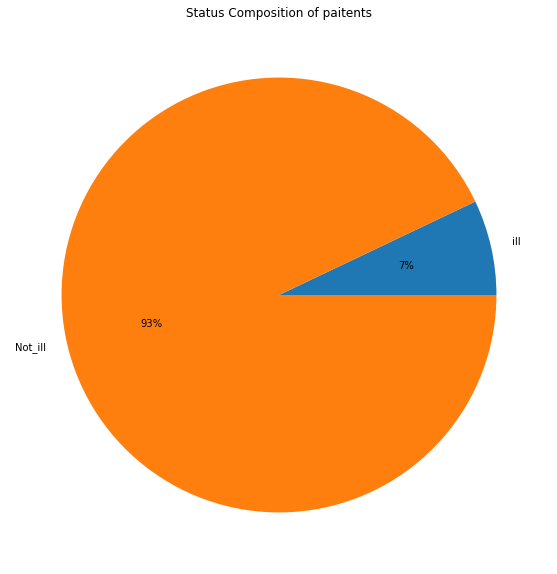

In [16]:
fig, ax1 = plt.subplots(1,1,figsize=(10,10)) #ax1,ax2 refer to your two pies
Status = ['ill', 'Not_ill']
data = [count_ill_patients,count_not_ill_patients]
ax1.pie(data,labels = Status,autopct='%.0f%%') #plot first pie
ax1.set_title('Status Composition of paitents')
 
# show plot
plt.show()


We see that the training data is not balanced - the percentage of patients that had sepsis is 7% of the data, which means that 93% of the data consist of patients who weren't ill. We need to remember this in further analysis to get good results.

### Demographics

#### Age

The average age of our patients is :  61.668051999999754


(array([   0.,  108.,  832., 1250., 2386., 3765., 4695., 4339., 2424.,
         201.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 <BarContainer object of 10 artists>)

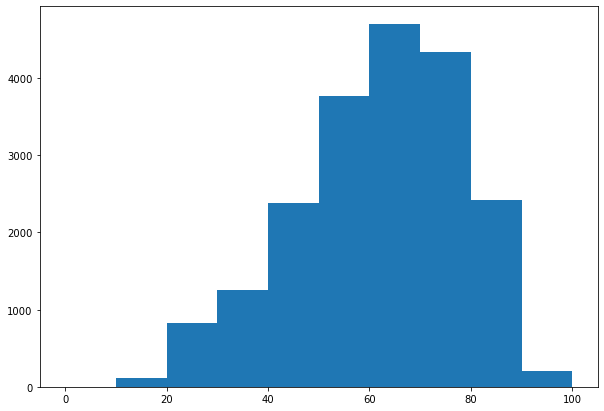

In [17]:
list_ages = []
for k,v in patients_dict.items():
    list_ages.append(v['Age'][0])
print("The average age of our patients is : ",sum(list_ages)/len(list_ages))
# Creating histogram
fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(np.array(list_ages), bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

The average age of our ill patients is :  62.25093992932861


(array([  0.,   5.,  64.,  82., 170., 256., 311., 340., 170.,  17.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 <BarContainer object of 10 artists>)

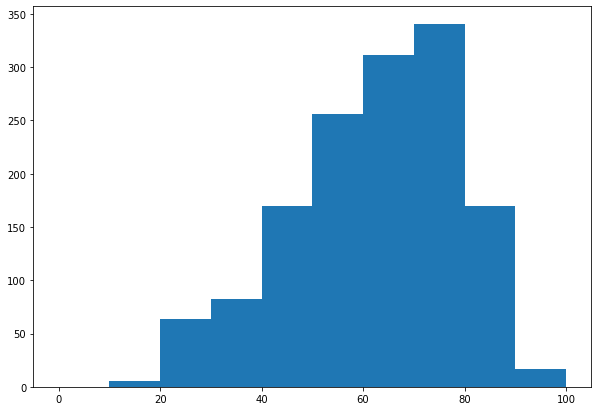

In [18]:
ill_list_ages = []
for k,v in ill_patients_dict.items():
    ill_list_ages.append(v['Age'][0])
print("The average age of our ill patients is : ",sum(ill_list_ages)/len(ill_list_ages))
# Creating histogram
fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(np.array(ill_list_ages), bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

The average age of our not ill patients is :  61.62367285445235


(array([   0.,  103.,  768., 1168., 2216., 3509., 4384., 3999., 2254.,
         184.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 <BarContainer object of 10 artists>)

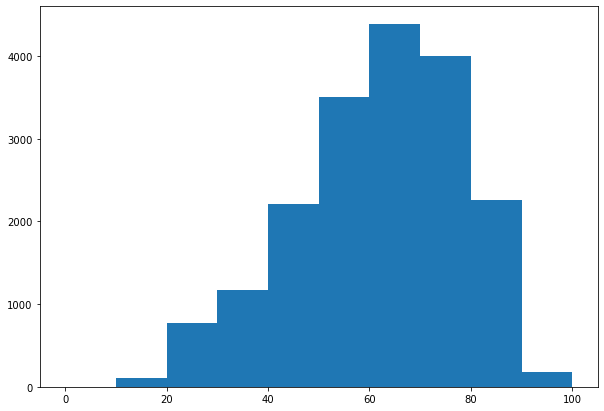

In [19]:
not_ill_list_ages = []
for k,v in not_ill_patients_dict.items():
    not_ill_list_ages.append(v['Age'][0])
print("The average age of our not ill patients is : ",sum(not_ill_list_ages)/len(not_ill_list_ages))
# Creating histogram
fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(np.array(not_ill_list_ages), bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

percent of ill people in age group 10 - 20 is :  4.316546762589928
percent of ill people in age group 20 - 30 is :  7.420494699646643
percent of ill people in age group 30 - 40 is :  6.980392156862745
percent of ill people in age group 40 - 50 is :  6.881287726358149
percent of ill people in age group 50 - 60 is :  6.885758998435055
percent of ill people in age group 60 - 70 is :  6.530089628681178
percent of ill people in age group 70 - 80 is :  8.027468624200806
percent of ill people in age group 80 - 90 is :  6.932409012131716
percent of ill people in age group 90 - 100 is :  8.457711442786069


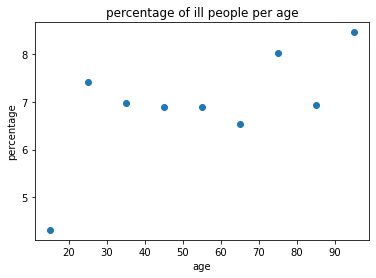

In [20]:
age_groups = [15, 25, 35, 45, 55, 65, 75, 85, 95]
proportions = []
for i in range(10,100,10):
    len_age_all = len([1 for age in list_ages if i < age <= i + 10])
    len_agg_ill = len([1 for age in ill_list_ages if i < age <= i + 10])
    proportions.append(100*len_agg_ill/len_age_all)
    print("percent of ill people in age group",i ,"-", i+10, "is : ",100*len_agg_ill/len_age_all)
plt.title("percentage of ill people per age")
plt.xlabel("age")
plt.ylabel("percentage")
plt.scatter(age_groups, proportions)
plt.show()


We see in graphs above the distribution of the age in all patients, the distribution of the age in ill patients and the distribution of the age in not ill patients. All the distribution very similar, and the average age in every group of those 3 are similar.

After looking at that, we try to look at the percent of ill patients in every age group (bins of 10 years). Here also we didn't get very informetive results because the results are very similar in all age groups. The intresting thing that in all the age groups, even in the oldest group the percentage of ill patients not high.

#### Gender

In [21]:
count_all_women = 0
for k,v in patients_dict.items():
    if v['Gender'][0] == 0:
        count_all_women += 1
count_all_men = len(patients_dict) - count_all_women
proportion_all_women = count_all_women / len(patients_dict)
print("proportion of all women is : ", proportion_all_women)

count_ill_women = 0
for k,v in ill_patients_dict.items():
    if v['Gender'][0] == 0:
        count_ill_women += 1
count_ill_men = len(ill_patients_dict) - count_ill_women
proportion_ill_women = count_ill_women/len(ill_patients_dict)
print("proportion of ill women is : ", proportion_ill_women)

proportion of all women is :  0.4445
proportion of ill women is :  0.41908127208480567


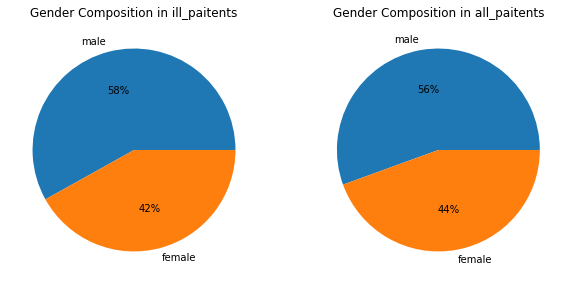

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10)) #ax1,ax2 refer to your two pies
Gender = ['male', 'female']
data = [1-proportion_ill_women,proportion_ill_women]
data2 = [1-proportion_all_women,proportion_all_women]
ax1.pie(data,labels = Gender,autopct='%.0f%%') #plot first pie
ax1.set_title('Gender Composition in ill_paitents')
ax2.pie(data2,labels = Gender,autopct='%.0f%%') #plot first pie
ax2.set_title('Gender Composition in all_paitents')
 
# show plot
plt.show()



We can see that our data is balanced according to gender, both in all the patients and the ill patients. 

#### Hospital administration time

In [23]:
list_HospAdmTime = []
for k,v in patients_dict.items():
    list_HospAdmTime.append(-v['HospAdmTime'][0])
print("The average HospAdmTime of our patients is : ",sum(list_HospAdmTime)/len(list_HospAdmTime))

list_ill_HospAdmTime = []
for k,v in ill_patients_dict.items():
    list_ill_HospAdmTime.append(-v['HospAdmTime'][0])
print("The average HospAdmTime of our ill patients is : ",sum(list_ill_HospAdmTime)/len(list_ill_HospAdmTime))

The average HospAdmTime of our patients is :  50.975196000003194
The average HospAdmTime of our ill patients is :  74.68658657243813


Here we can see a clear difference between hospital administration time compering ill patients to all patients. This could indicate that this feature is valuebale.

## Missing Data


In [24]:
labs_df = df[labs]
vitals_df = df[vitals]
demogs_df = df[demogs]
df_sepsis = df[df['SepsisLabel'] == 1]
df_not_sepsis = df[df['SepsisLabel'] == 0]

In [25]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values()

patient_id           0.000000
ICULOS               0.000000
HospAdmTime          0.000000
Gender               0.000000
Age                  0.000000
SepsisLabel          0.000000
HR                   9.952611
MAP                 12.551122
O2Sat               13.120266
SBP                 14.710585
Resp                15.460834
DBP                 31.222402
Unit1               38.910491
Unit2               38.910491
Temp                66.091251
Glucose             82.850280
Potassium           90.725169
Hct                 91.158519
FiO2                91.843321
Hgb                 92.644177
pH                  93.096075
BUN                 93.185898
WBC                 93.637266
Magnesium           93.747491
Creatinine          93.950984
Platelets           94.102014
Calcium             94.189320
PaCO2               94.488598
BaseExcess          94.592597
Chloride            95.525670
HCO3                95.882446
Phosphate           96.056660
EtCO2               96.539956
SaO2      

In [26]:
plt.rcParams["figure.figsize"] = (20,5)

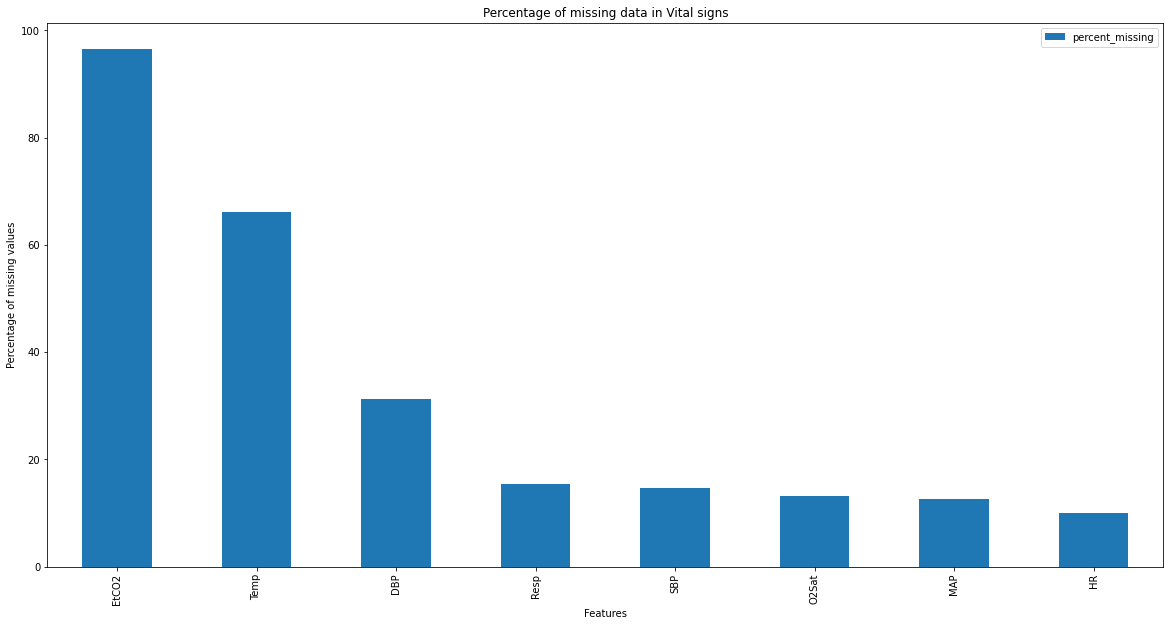

In [27]:
missing_vitals = vitals_df.isnull().sum() * 100 / len(vitals_df)
missing_vitals_df = pd.DataFrame({'percent_missing': missing_vitals,'column_name': vitals_df.columns})
missing_vitals_df.sort_values('percent_missing', inplace=True,ascending=False)
missing_vitals_df.plot.bar(figsize=(20,10))
plt.xlabel('Features')
plt.ylabel('Percentage of missing values')
plt.title(f'Percentage of missing data in Vital signs')
plt.show()

We see from the plot that the EtCO2 and Temp features out of the vital signs have a lot of missing data. When we will do additional preprocess of the data we will drop those features.

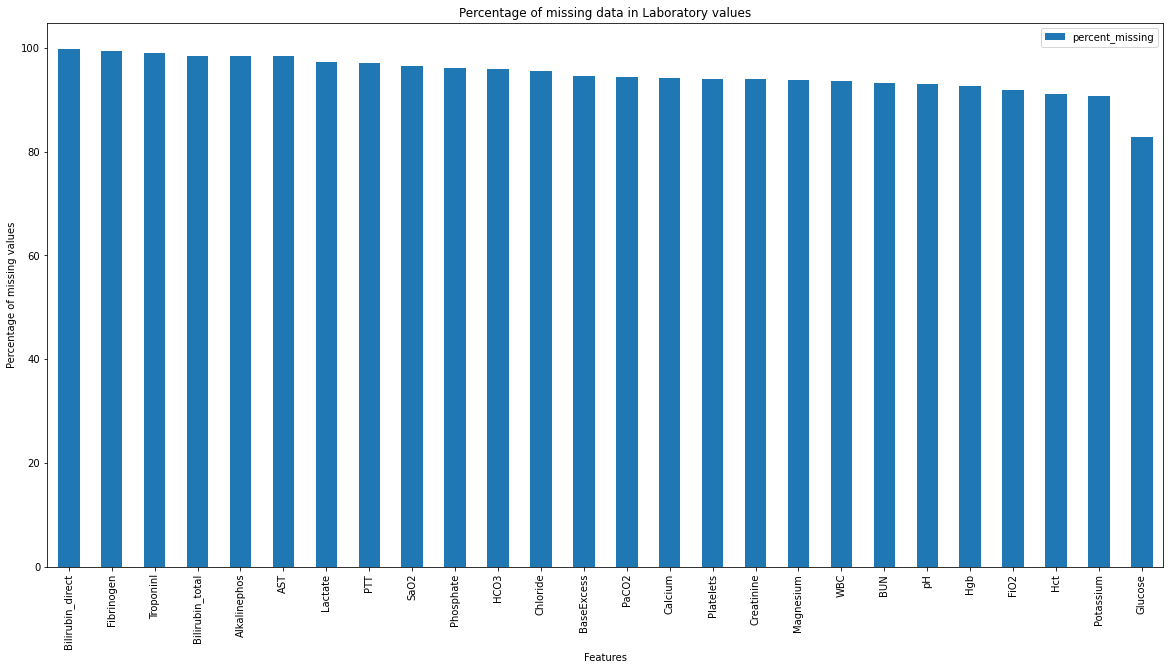

In [28]:
missing_labs = labs_df.isnull().sum() * 100 / len(labs_df)
missing_labs_df = pd.DataFrame({'column_name': labs_df.columns,
                                 'percent_missing': missing_labs})
missing_labs_df.sort_values('percent_missing', inplace=True,ascending=False)
missing_labs_df.plot.bar(figsize=(20,10))
plt.xlabel('Features')
plt.ylabel('Percentage of missing values')
plt.title(f'Percentage of missing data in Laboratory values')
plt.show()

There is a lot of missing values in the features of the laberatory values. This can be explained by the fact that usually these measures are taken only once or twice a day for a patient. 


In [29]:
dfs = []
all_missing = {col:0 for col in labs}
for k,v in patients_dict.items():
    for col in labs:
        if v[col].isnull().all():
            all_missing[col] += 1


In [30]:
all_missing_pct = {col: 100 * num_missing/20000 for col,num_missing in all_missing.items()}

In [31]:
missing_values_df = pd.DataFrame({'feature_name': labs_df.columns, 'percent_patients_with_all_missing':list(all_missing_pct.values())}).sort_values(by='percent_patients_with_all_missing').reset_index(drop=True)

The plot of the missing information for labs values was not informative so we decided to look at how many patients didn't have those features at all.
we can see that 3 of them are missing in over 80 percent of the petients, 9 of them are missing in over 60 percent (over 64 actually) and more than half of the features are missing in over 40 percent of the patients.
We need to consider this when we make additional preprocess of the data before running models.

## Feature distribution, comparative analysis between features

### Feature correlation

<ipython-input-32-443a19b5e926>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))


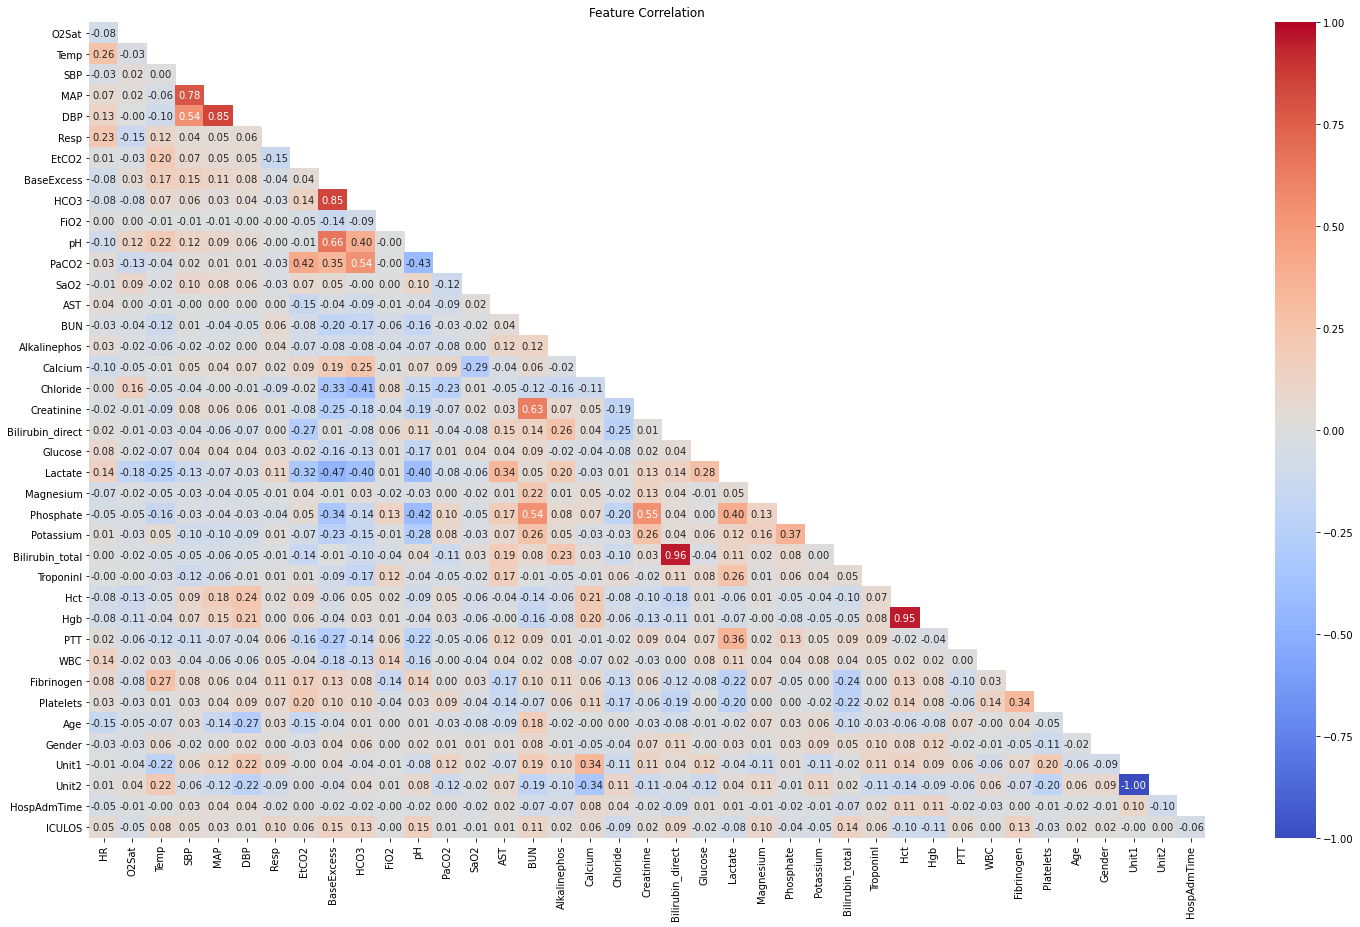

In [32]:
corr_matrix=df.iloc[:,:-2].corr()
fig, ax = plt.subplots(figsize=(25, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
mask = mask[1:, :-1]
corr = corr_matrix.iloc[1:,:-1].copy()
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',vmin=-1, vmax=1)
plt.yticks(rotation=0)
plt.title("Feature Correlation")
plt.show()

We can see that features "Unit1" and "Unit2" have a strong negative correlation (-1). 
In addition we see 4 more pairs of features that have a stong positive correlation (=>0.85).

### Feature Distribution

In [33]:
data_mean = df.groupby('patient_id').mean()
ill_mean = df_sepsis.groupby('patient_id').mean()
not_ill_mean = df_not_sepsis.groupby('patient_id').mean()

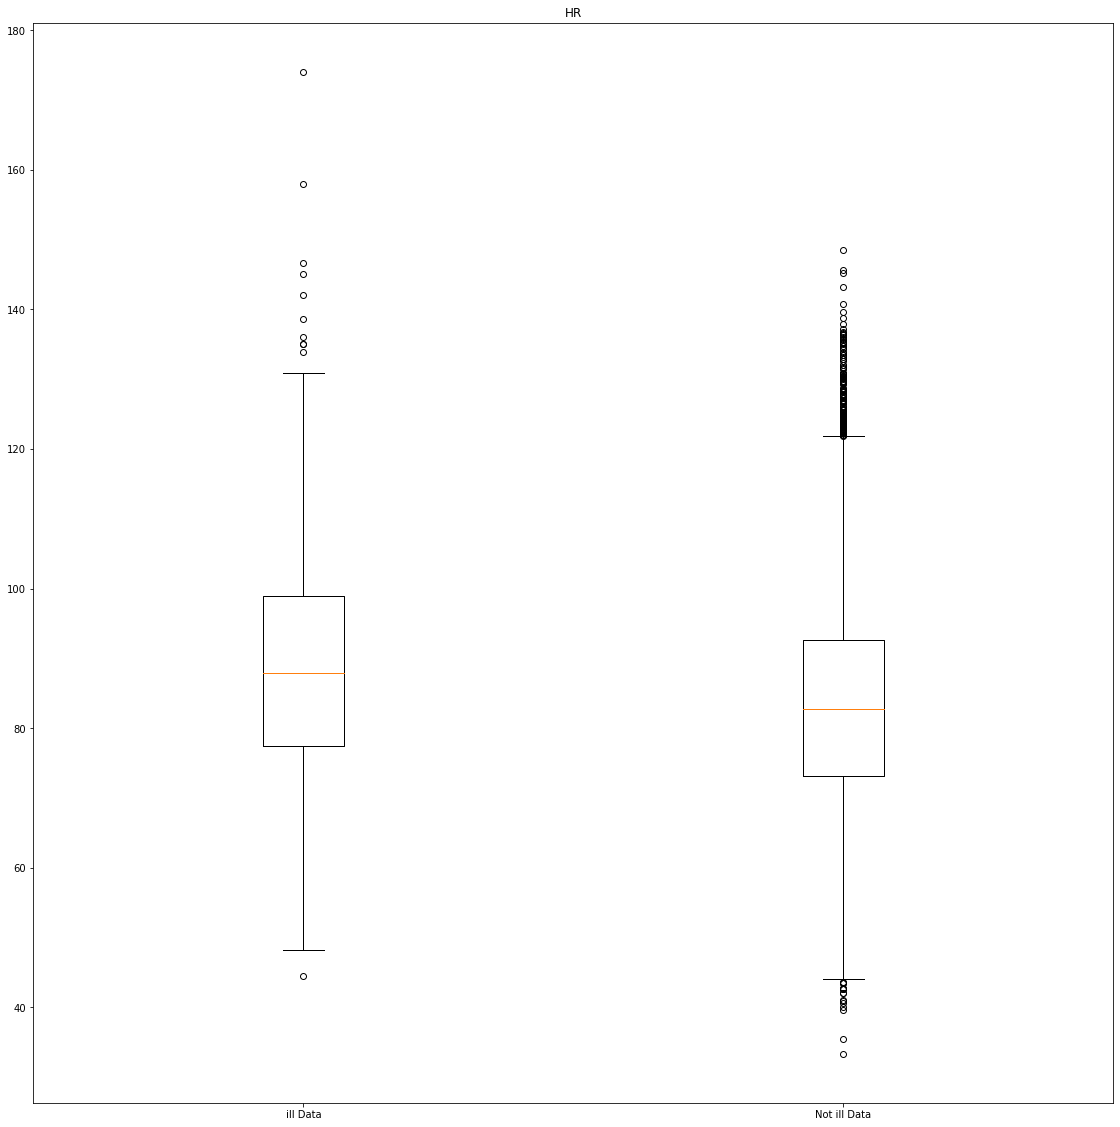

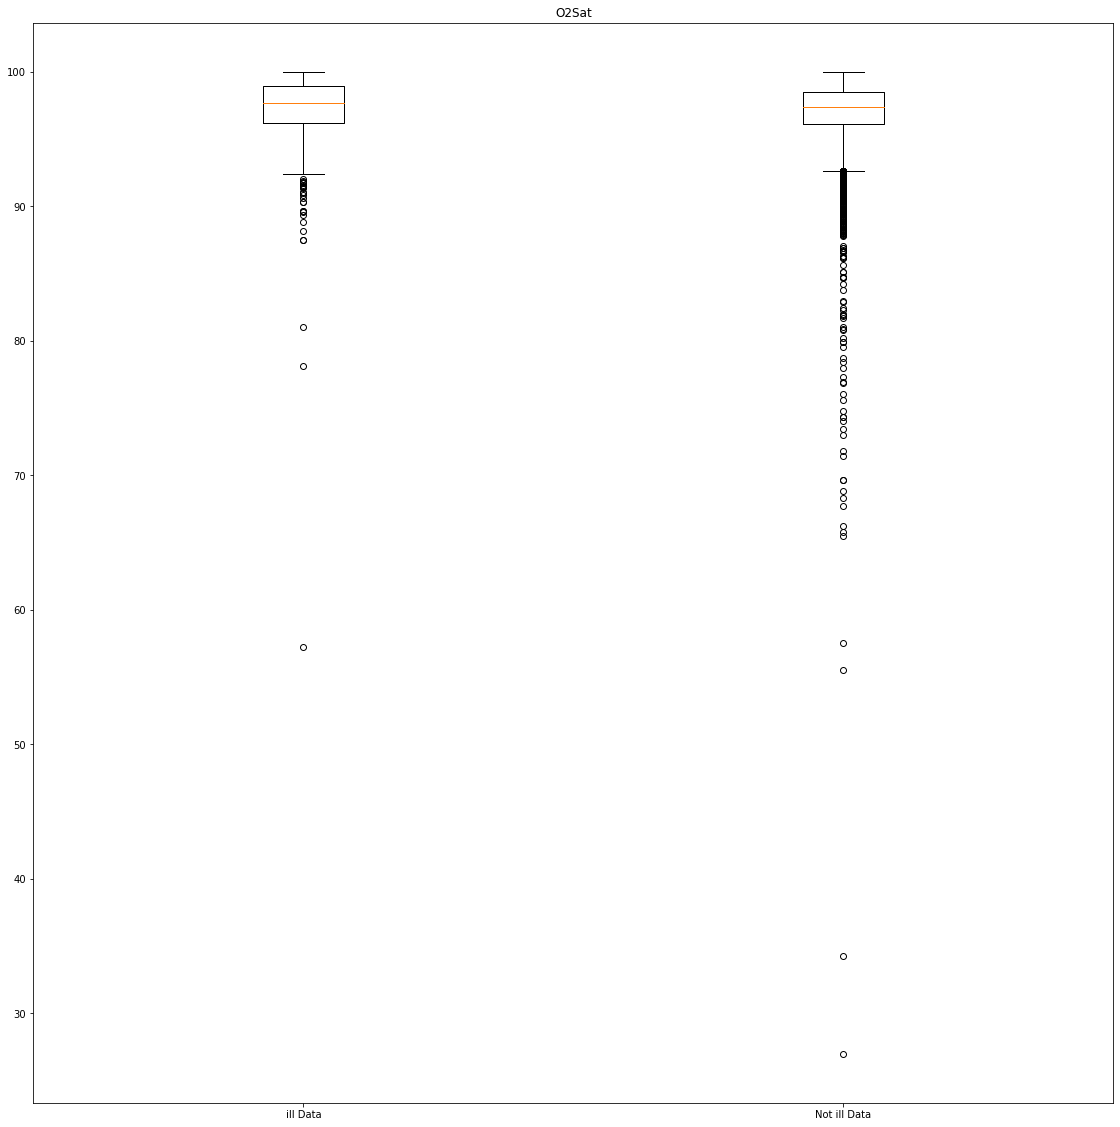

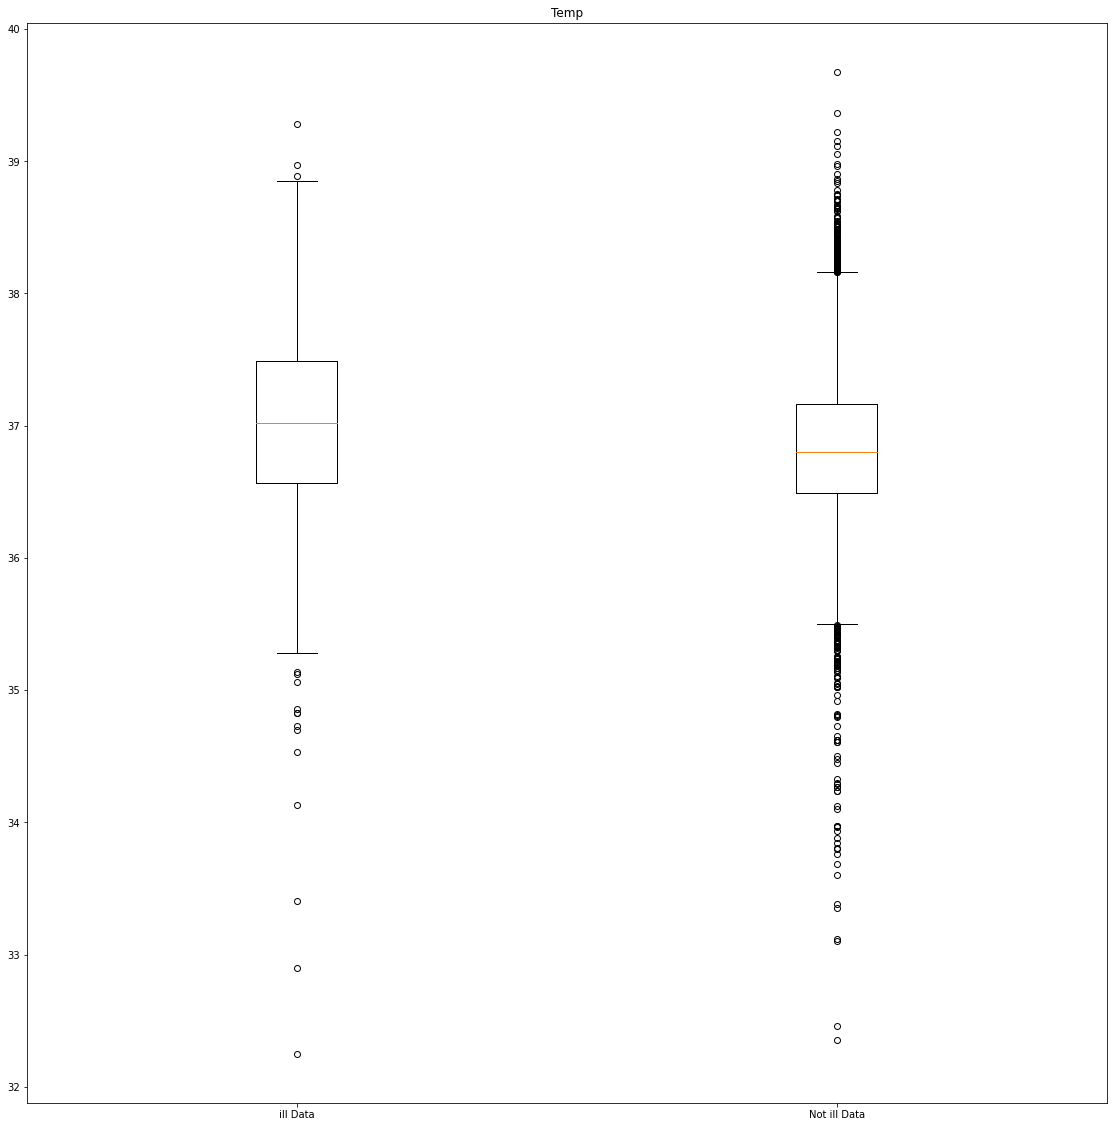

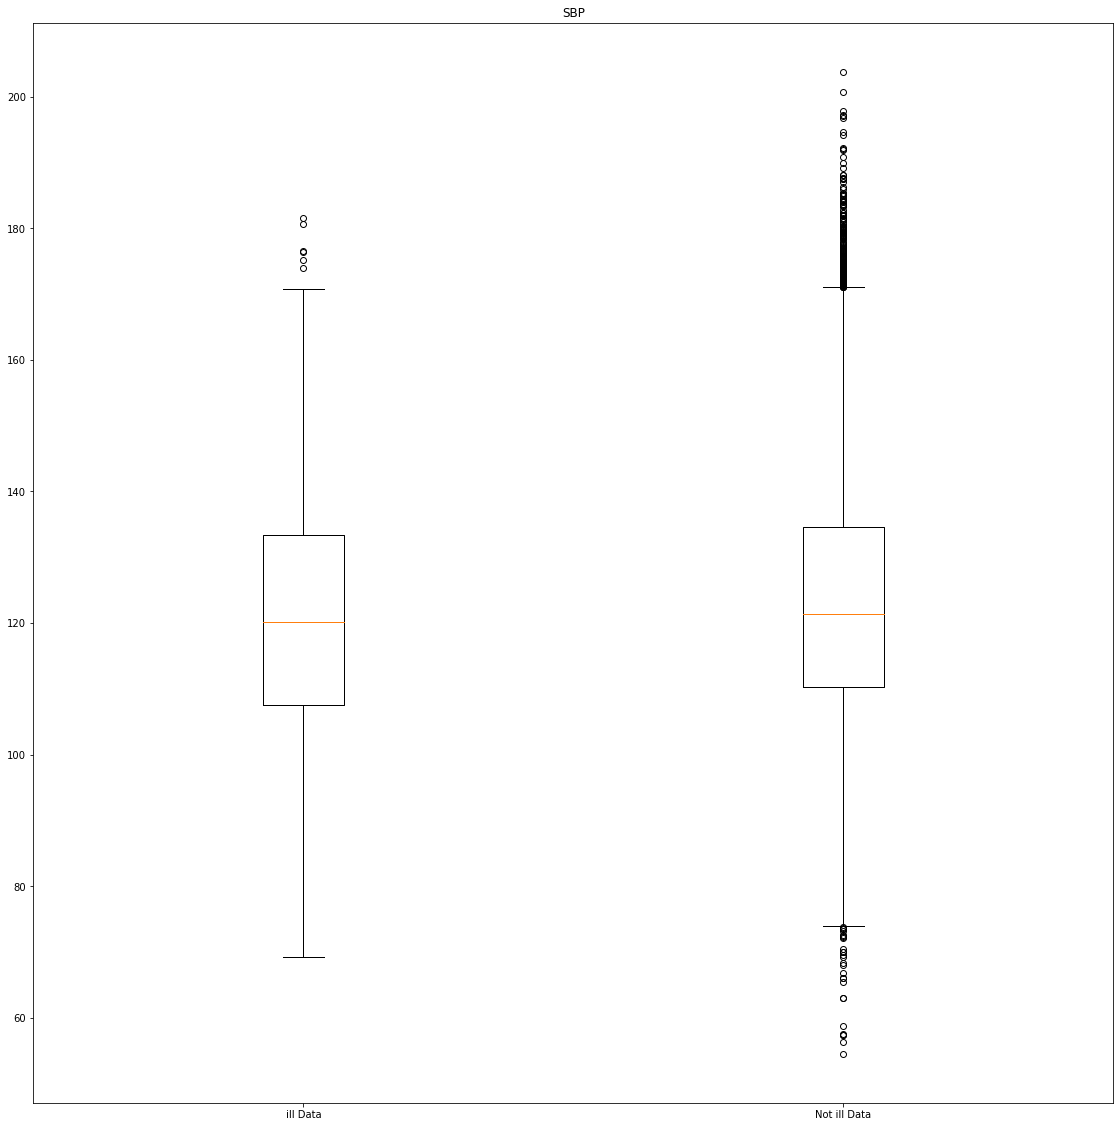

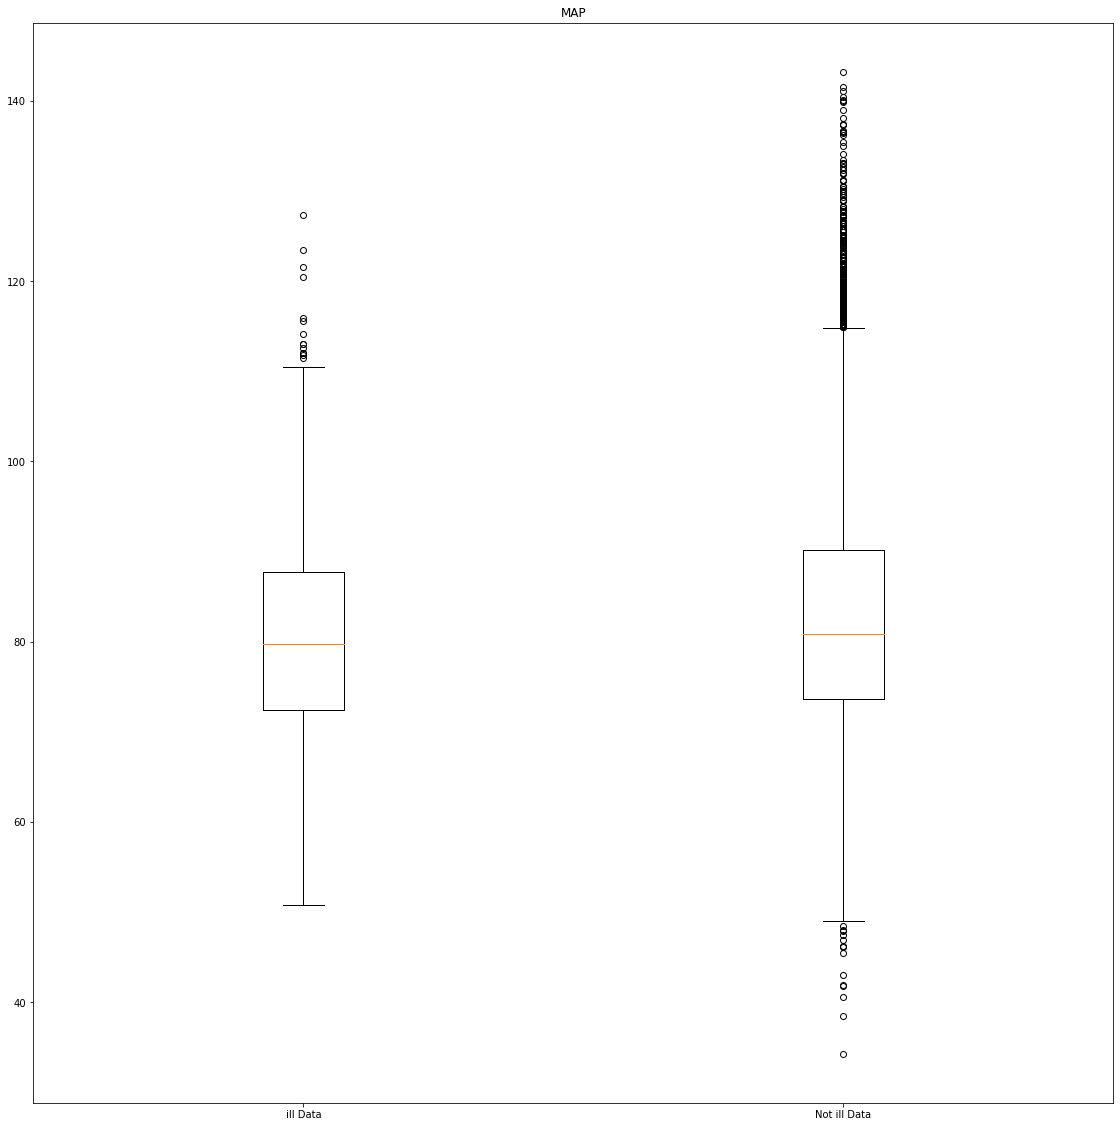

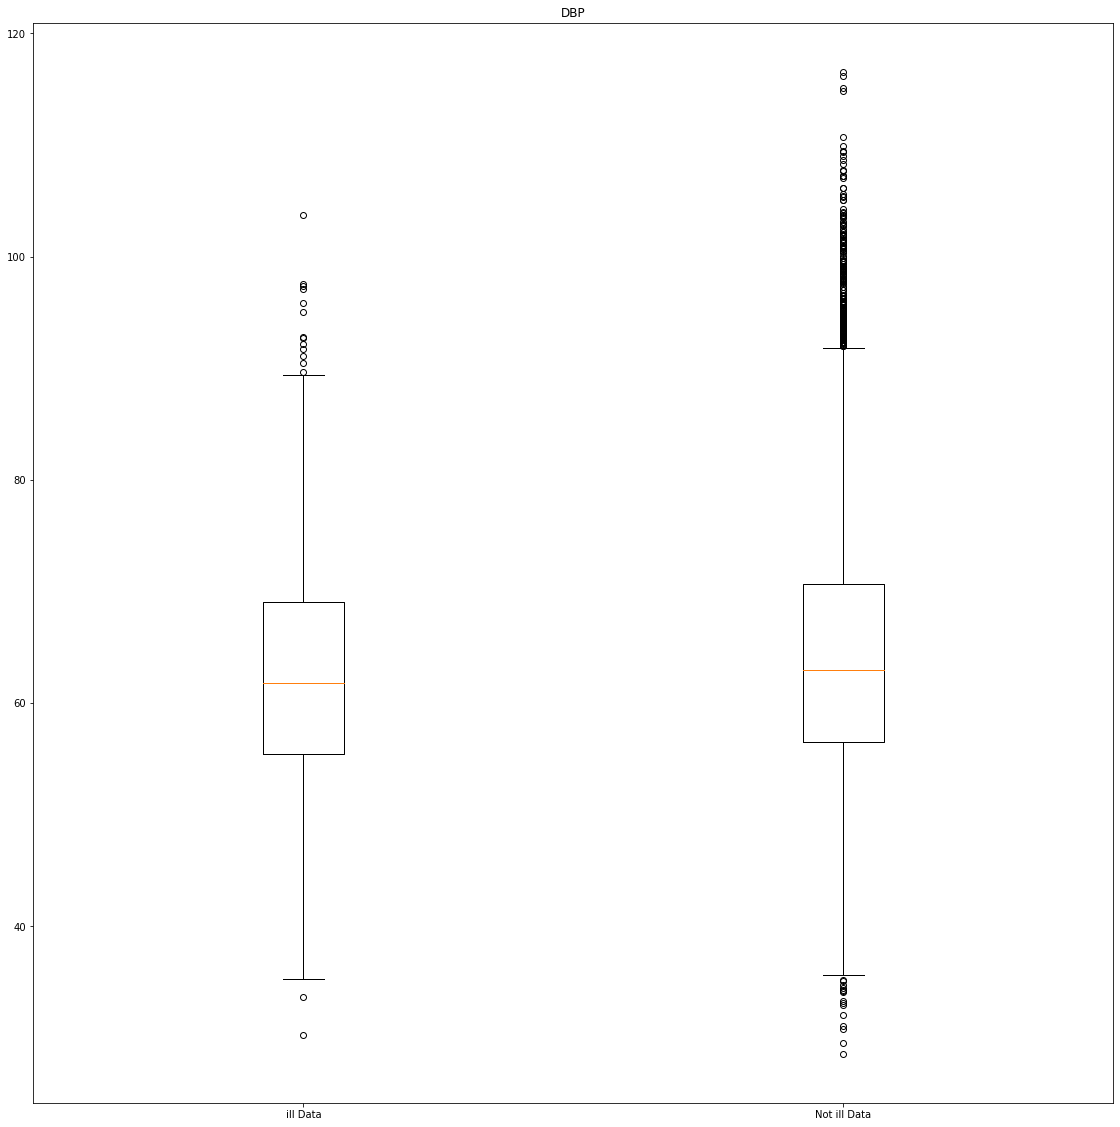

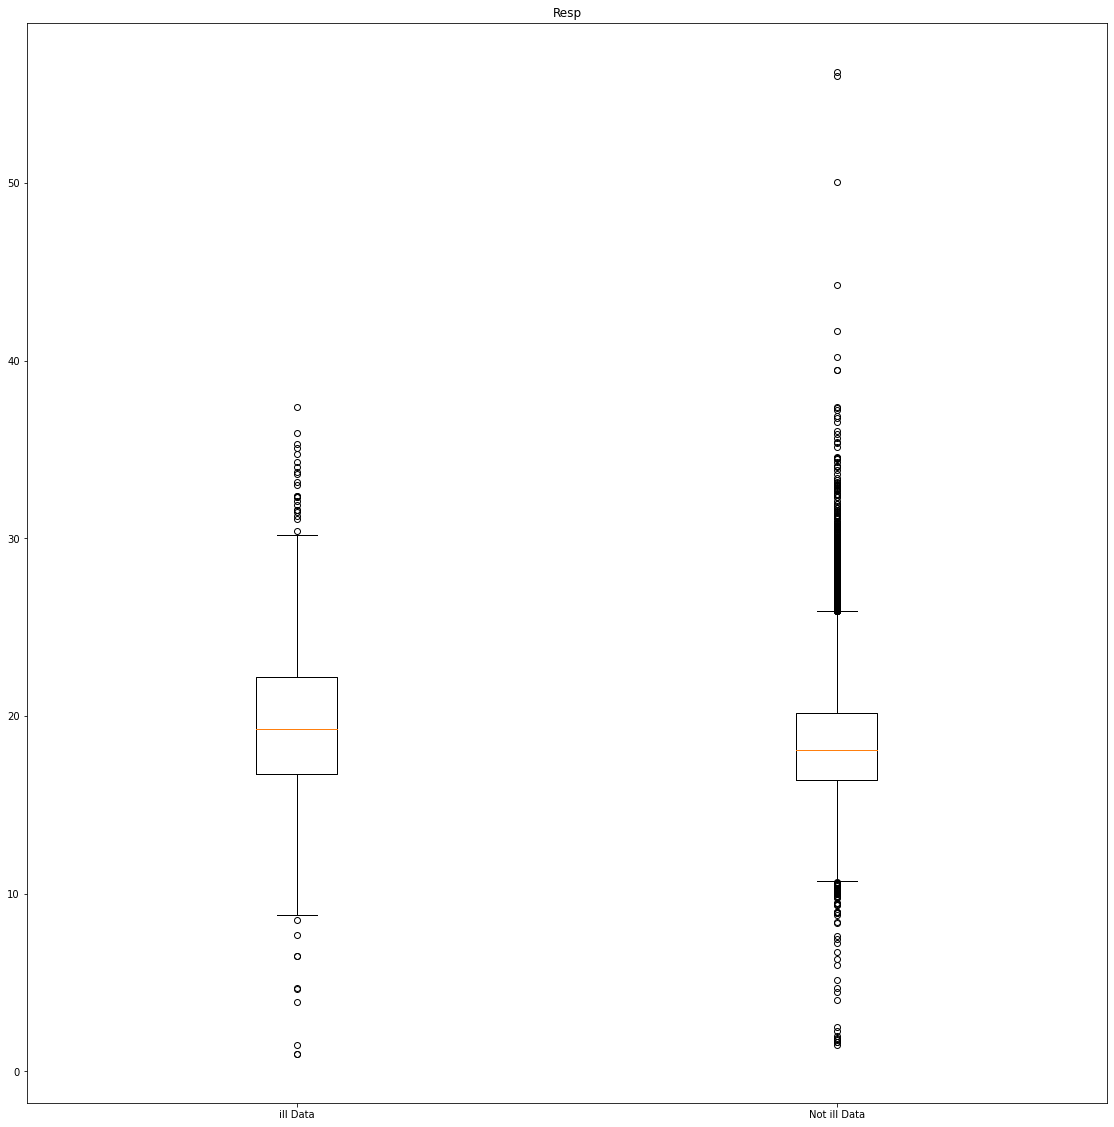

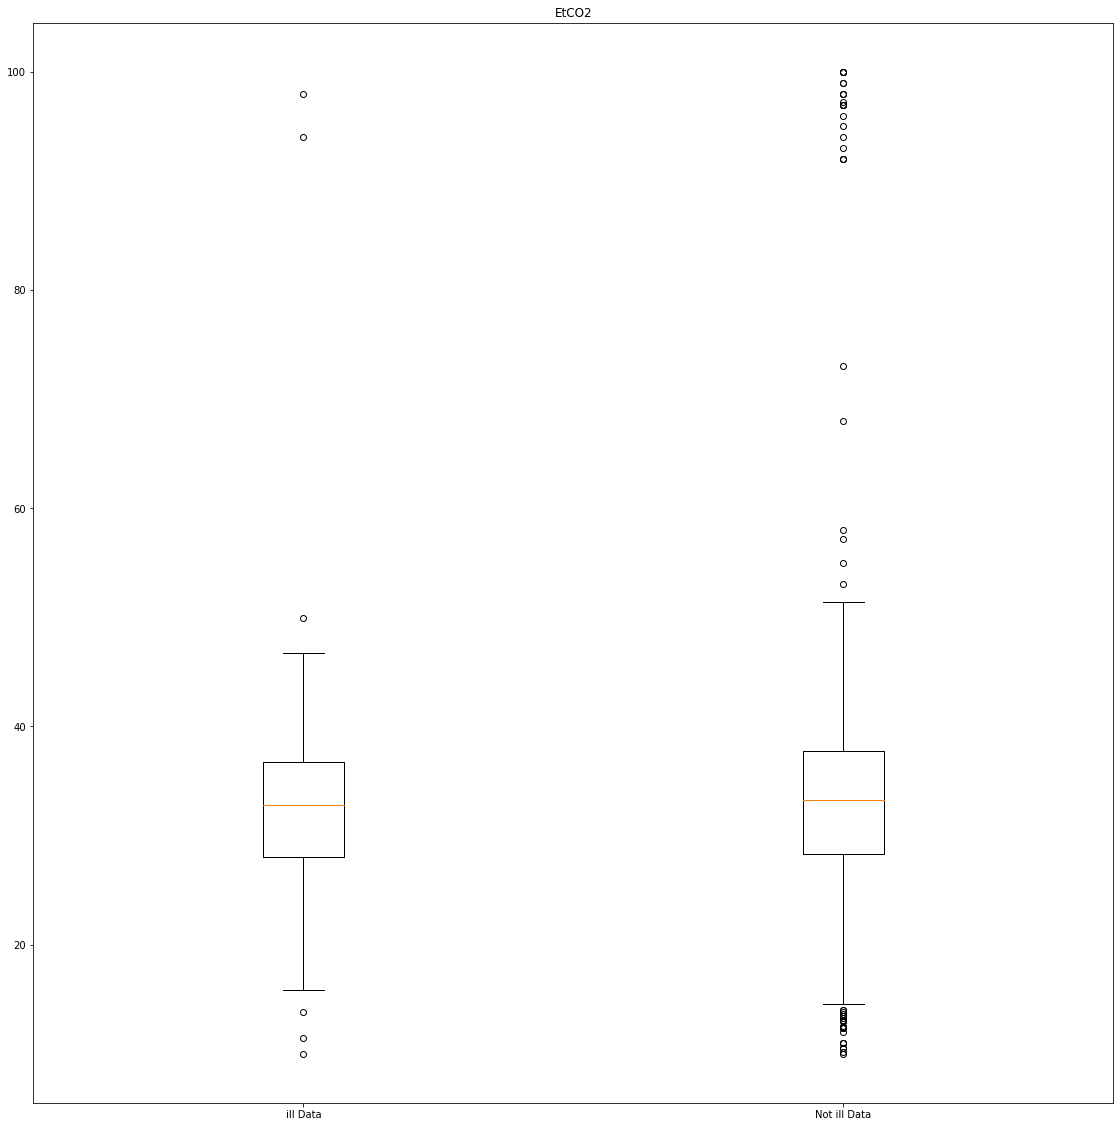

In [34]:
for vital in vitals:
    fig = plt.figure(figsize =(15, 15))

    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])

    # Creating plot
    bp = ax.boxplot([np.array(ill_mean[vital].dropna()), np.array(not_ill_mean[vital].dropna())])

    # show plot
    ax.set_xticklabels(['ill Data', 'Not ill Data'])
    ax.get_xaxis().tick_bottom()
    plt.title(vital)
    plt.show()

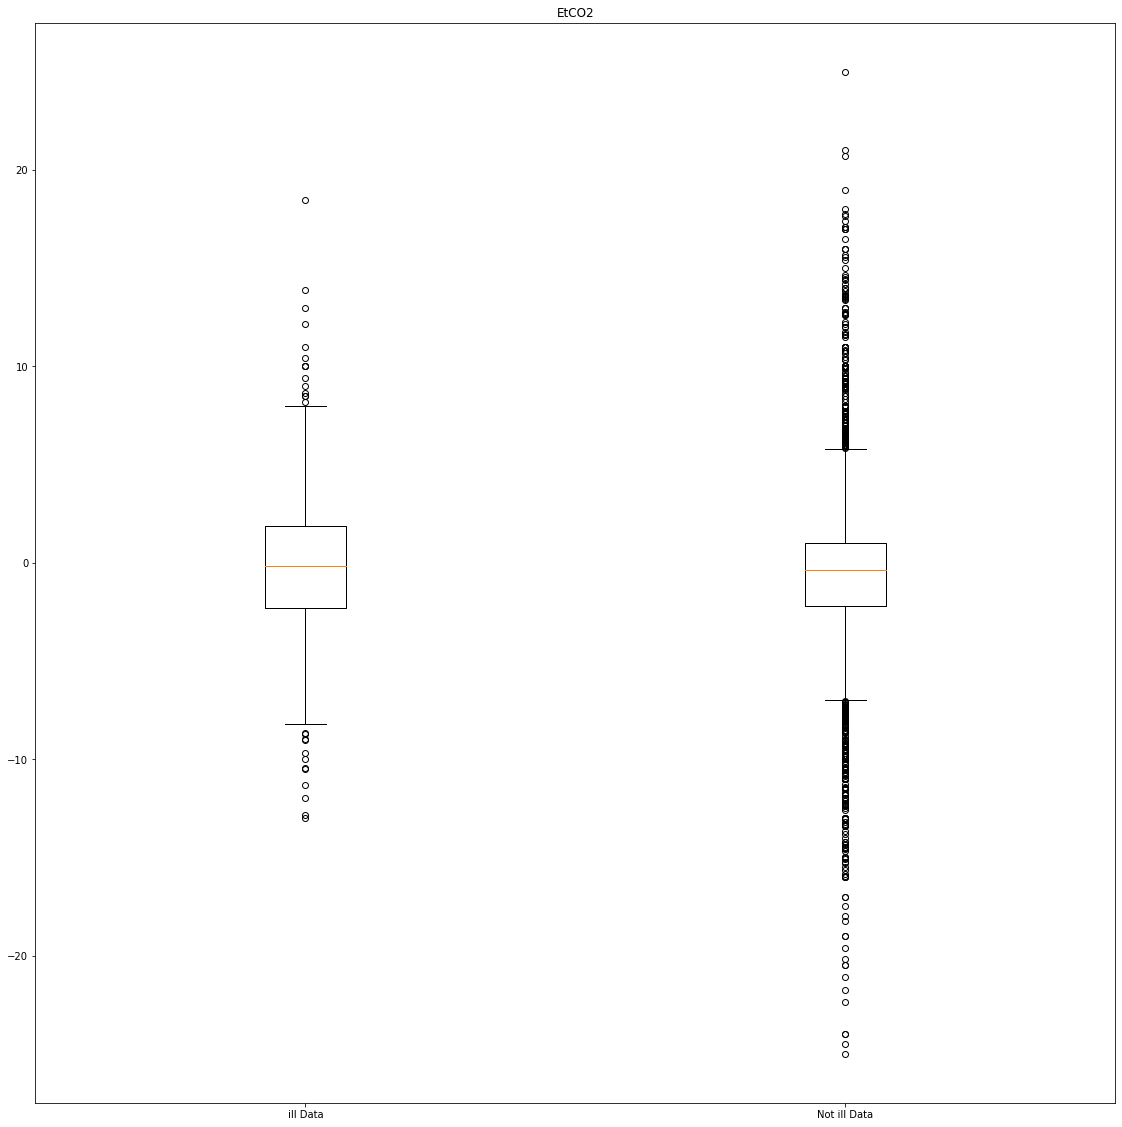

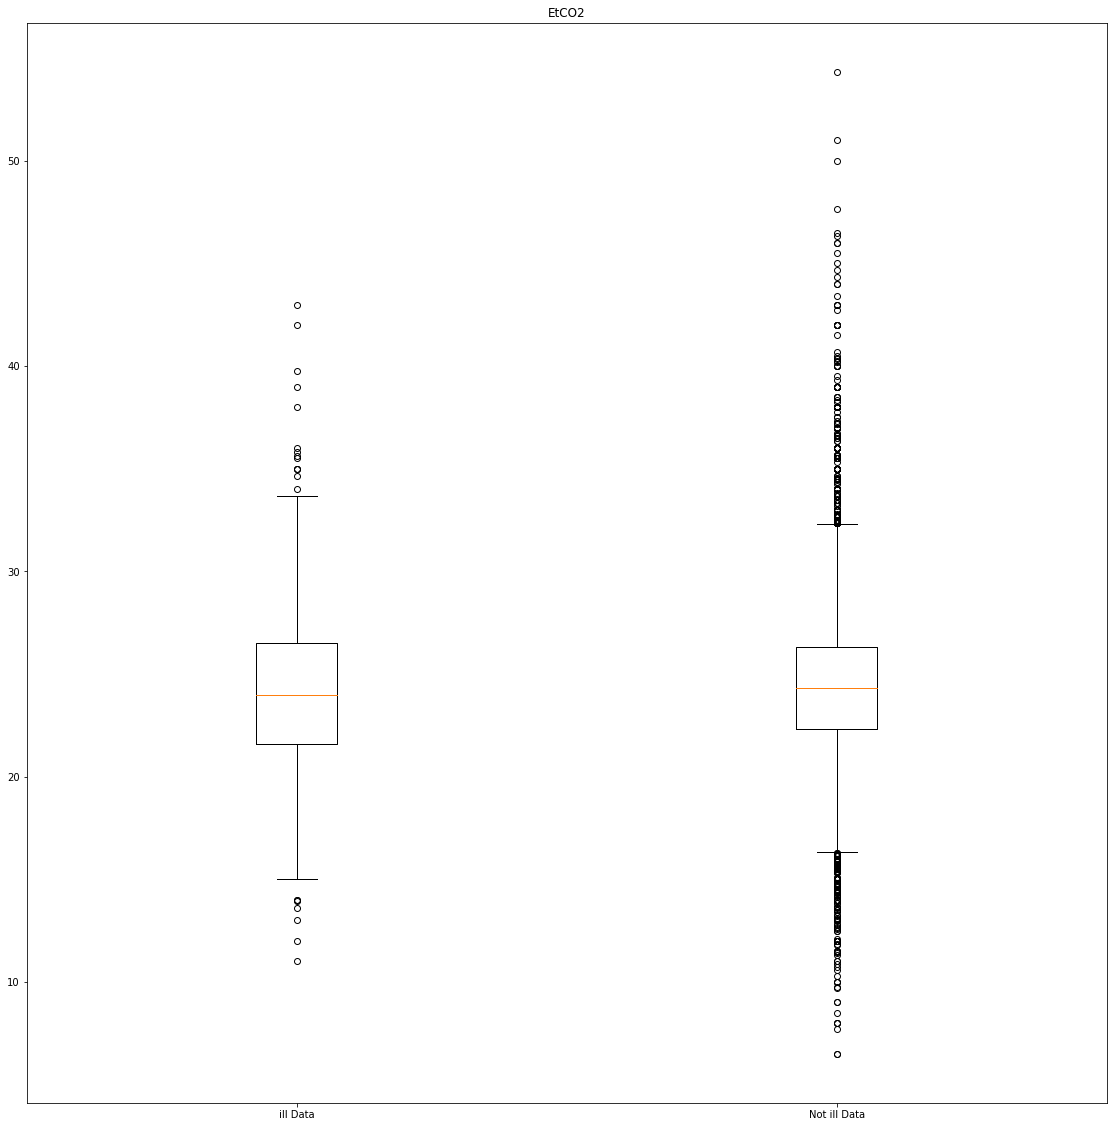

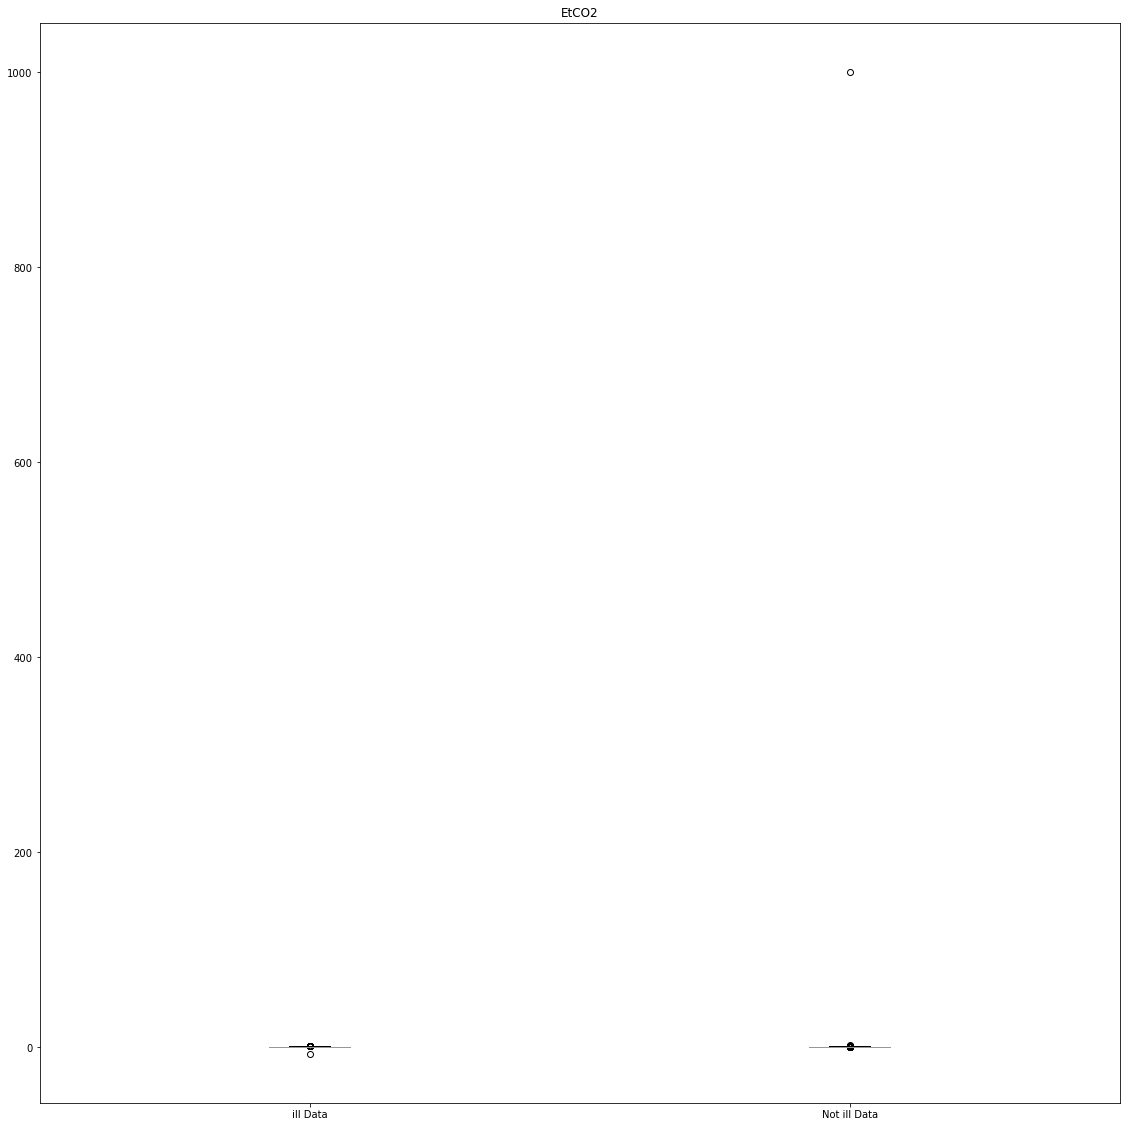

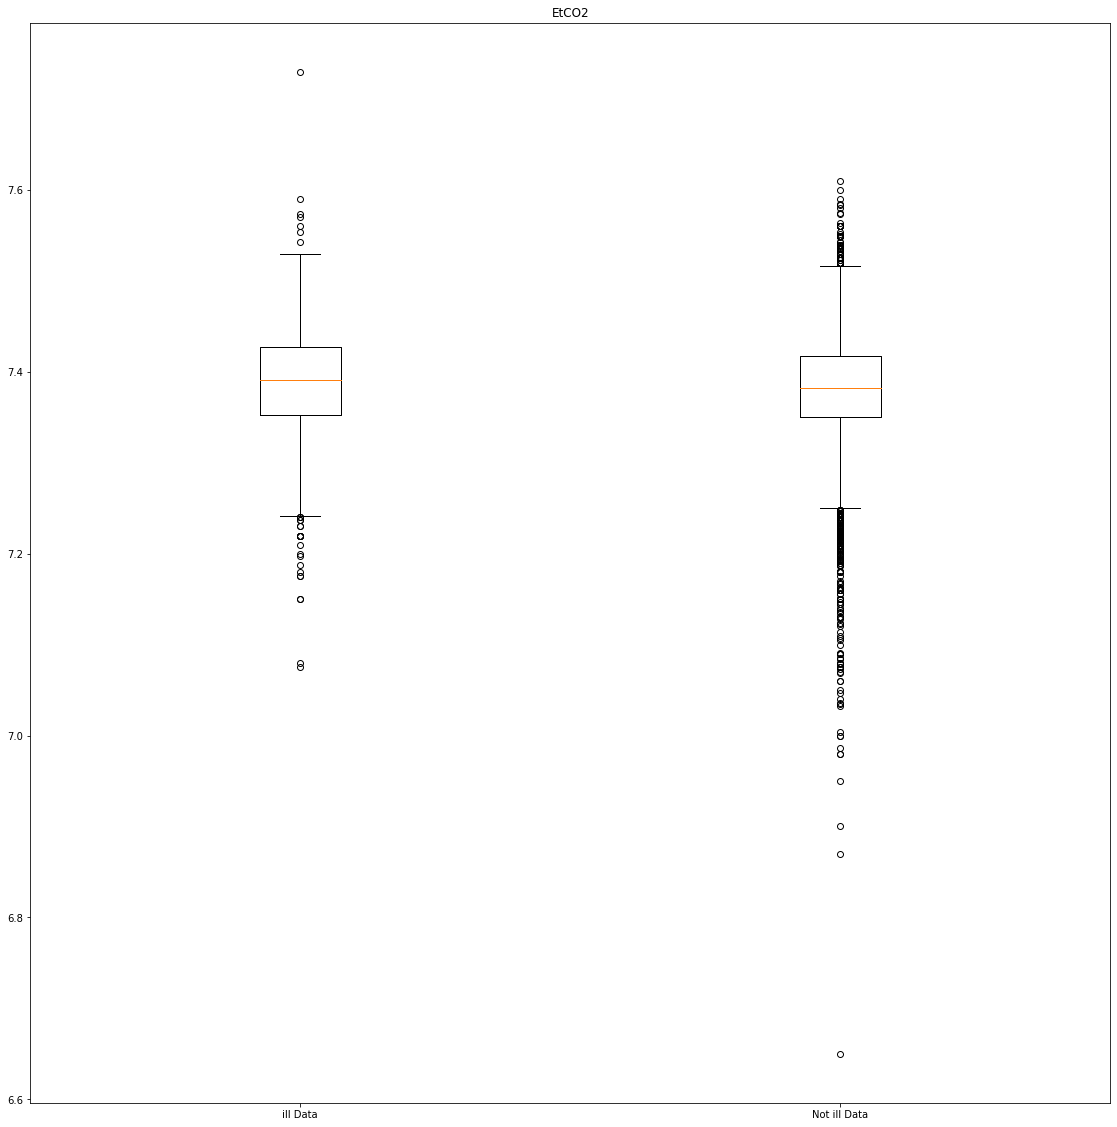

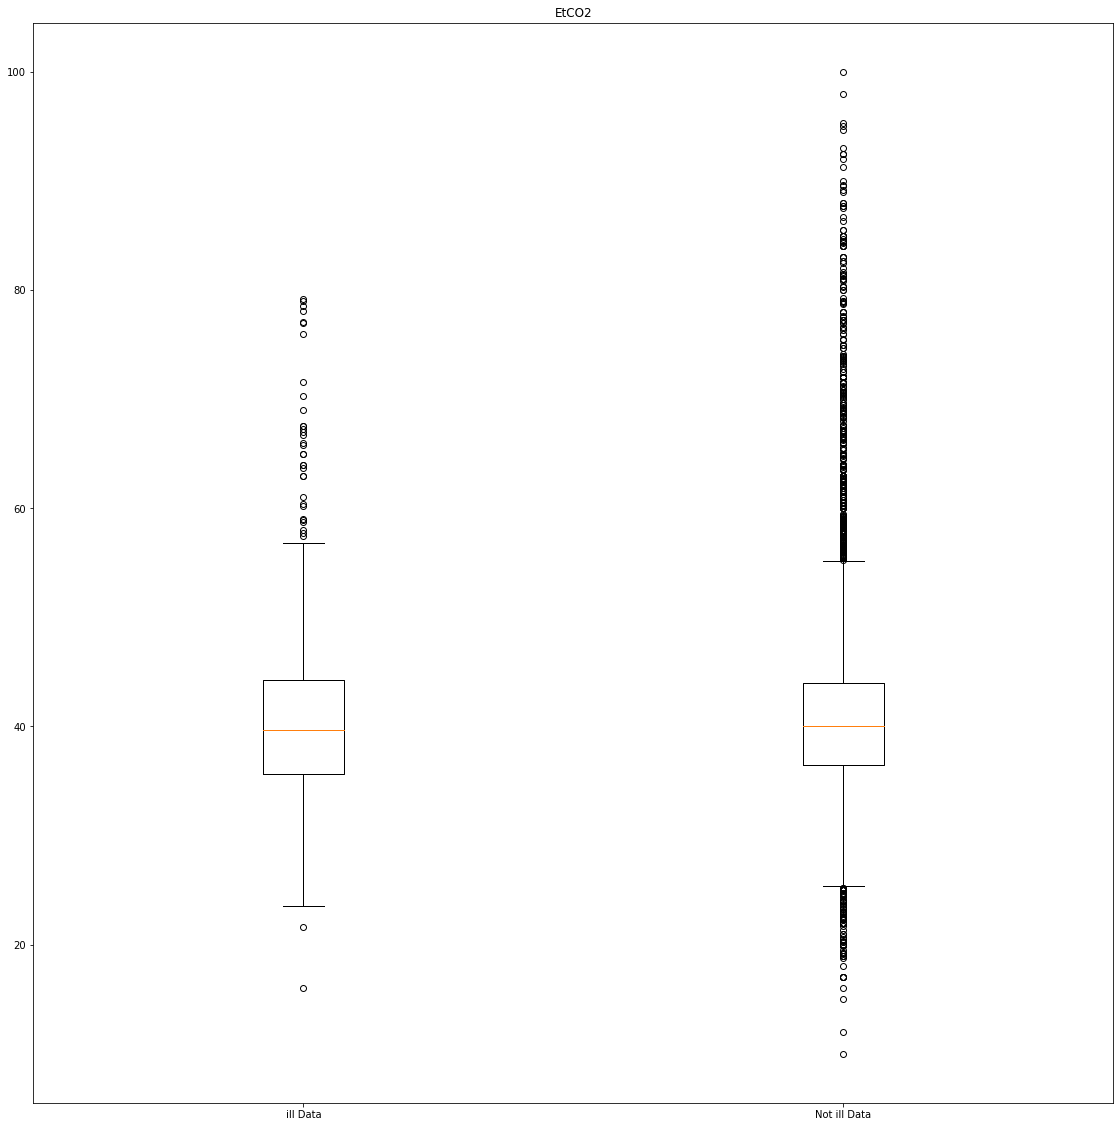

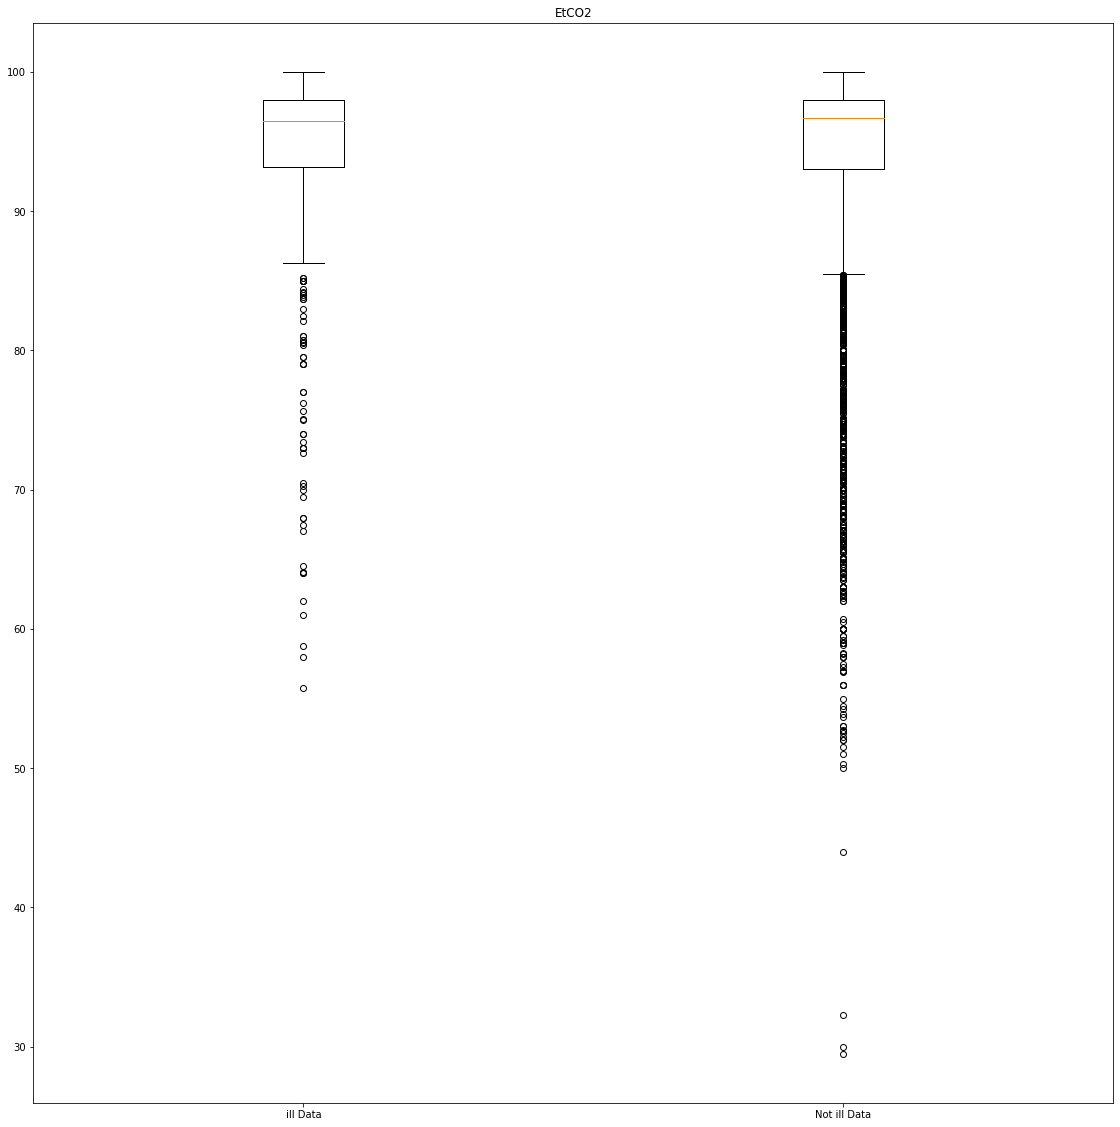

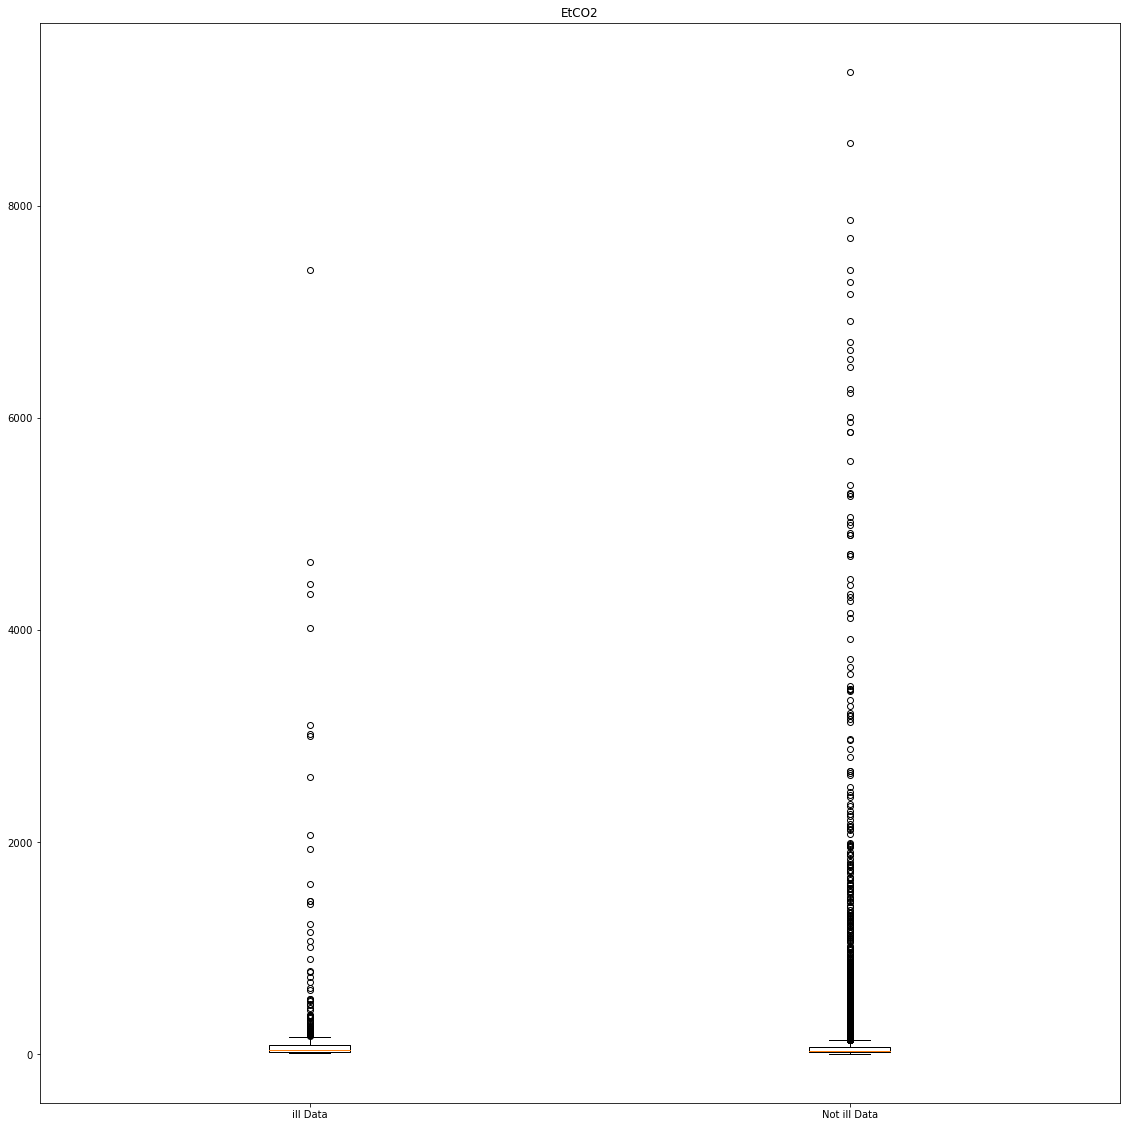

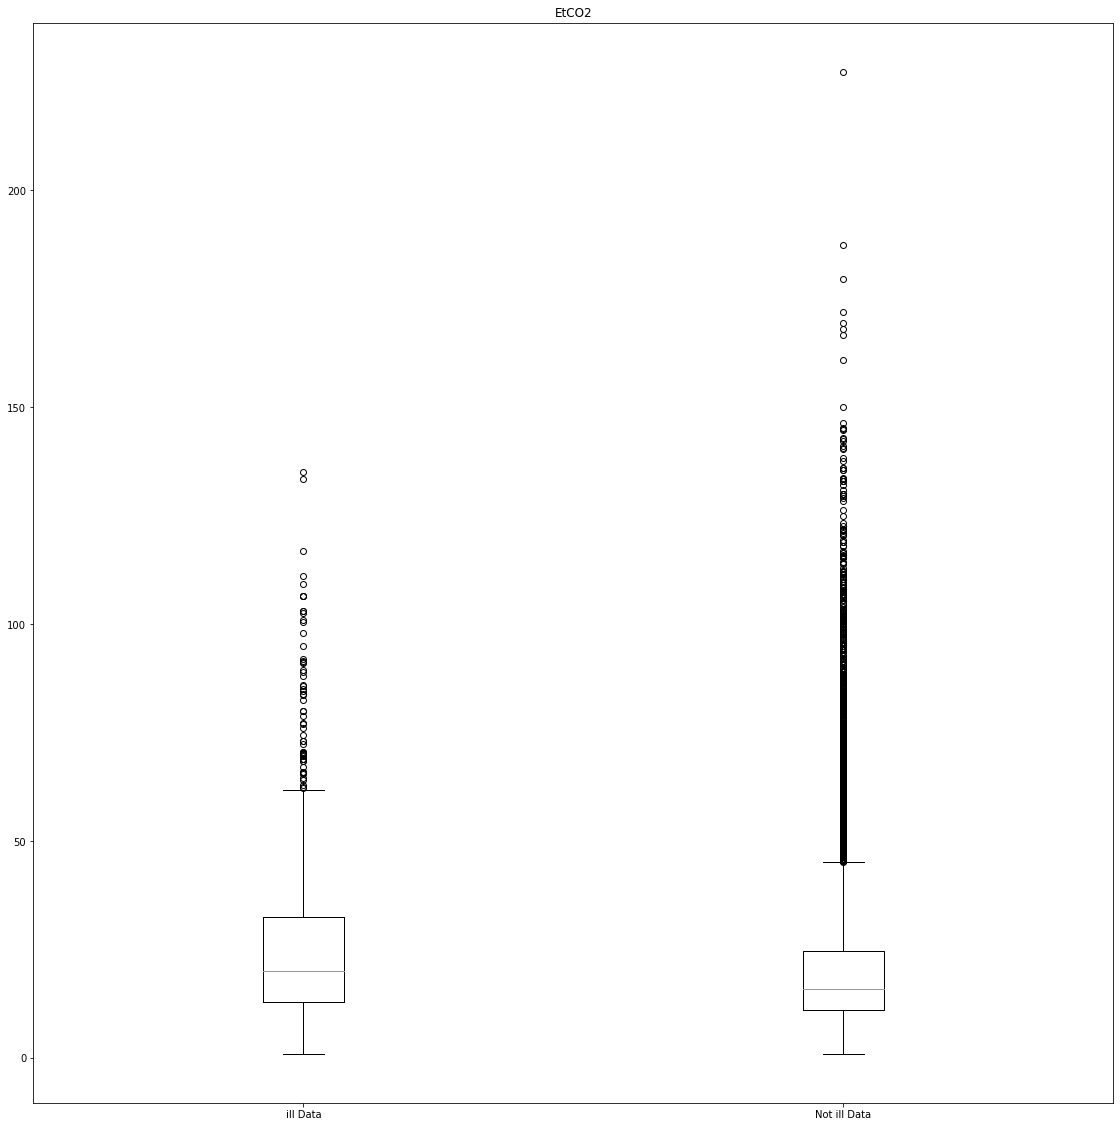

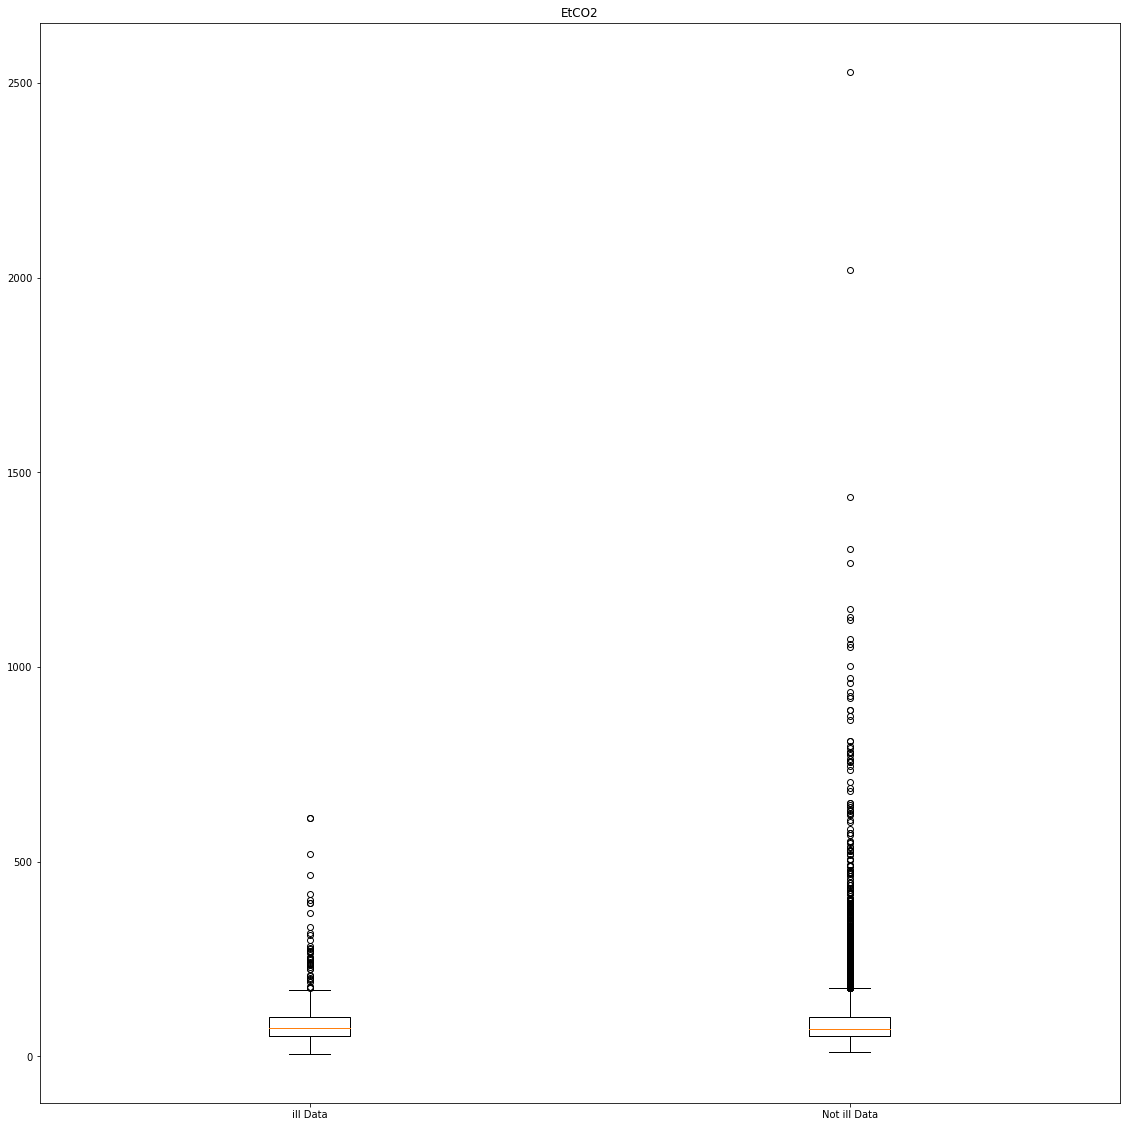

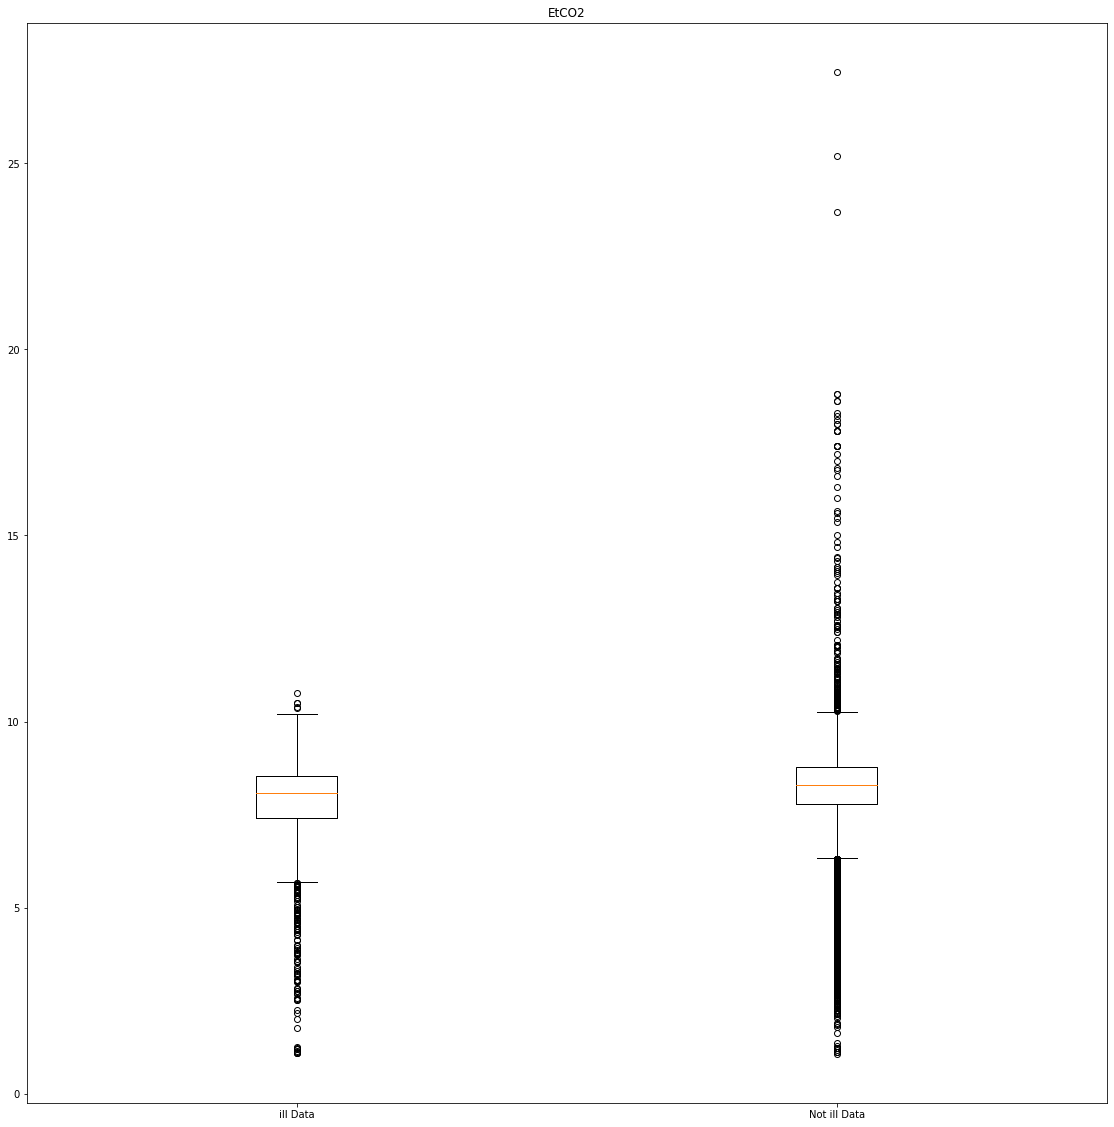

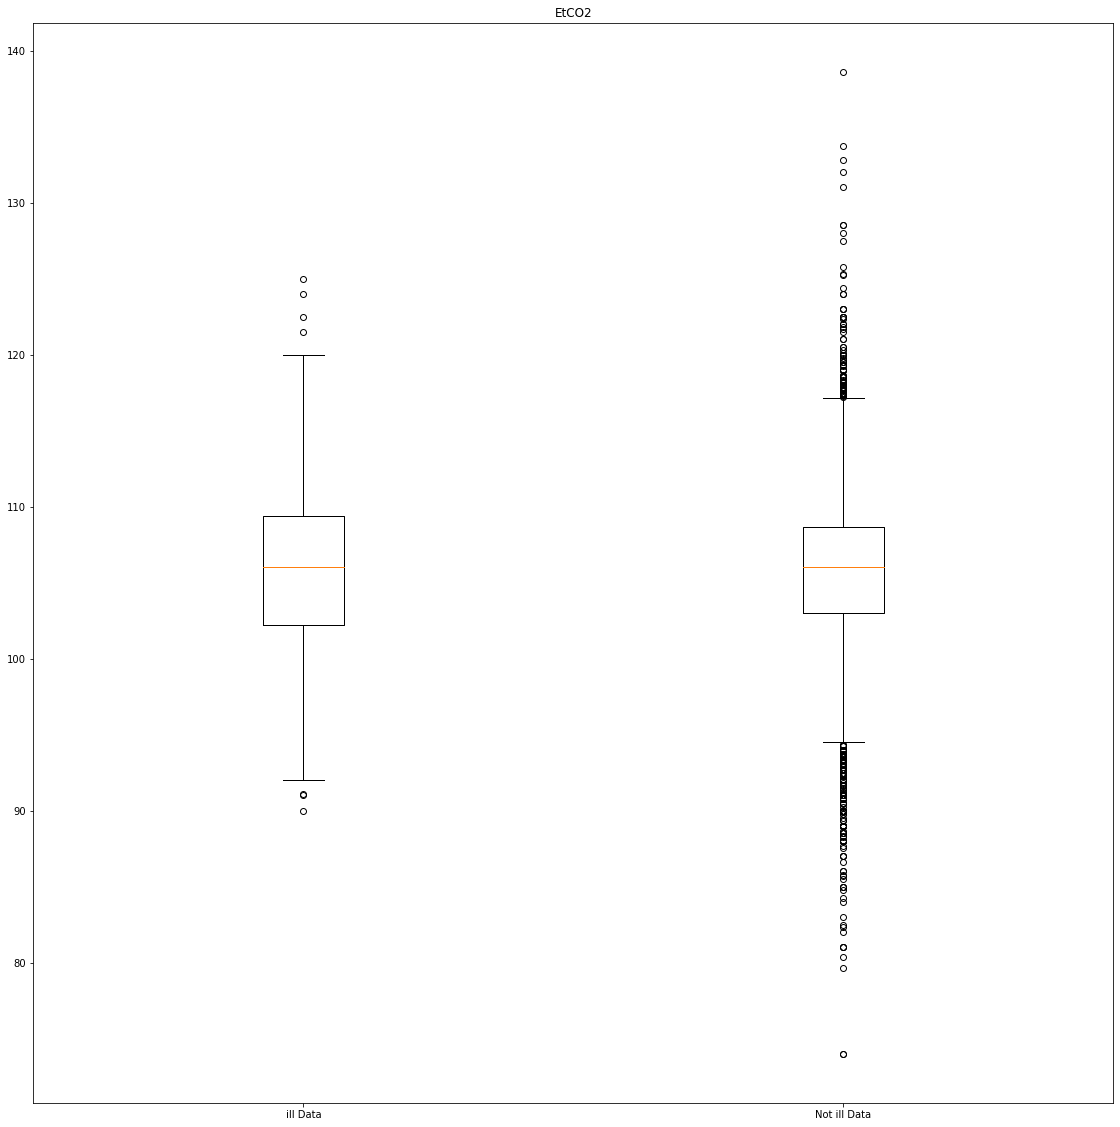

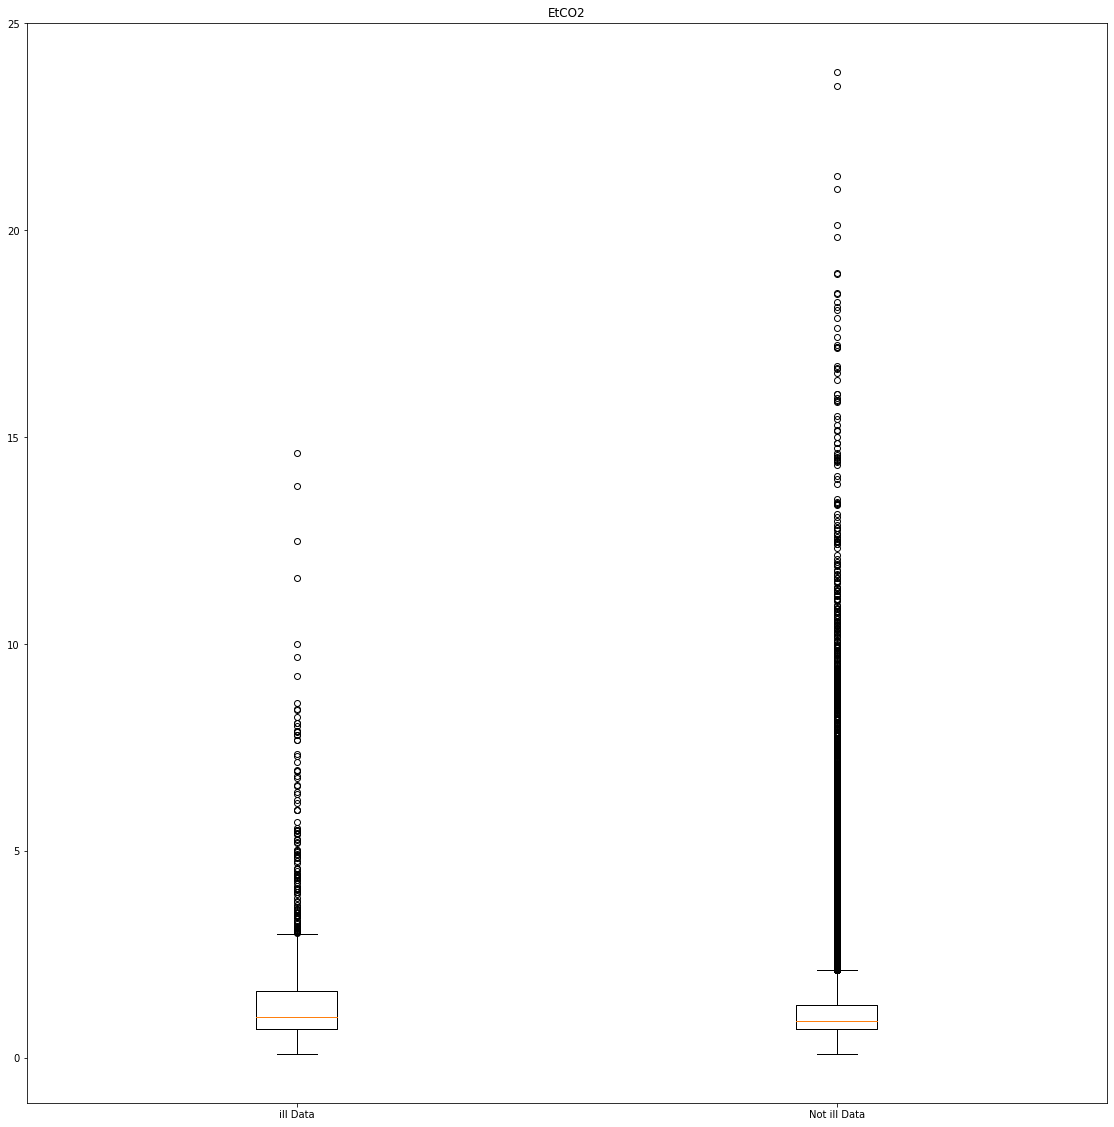

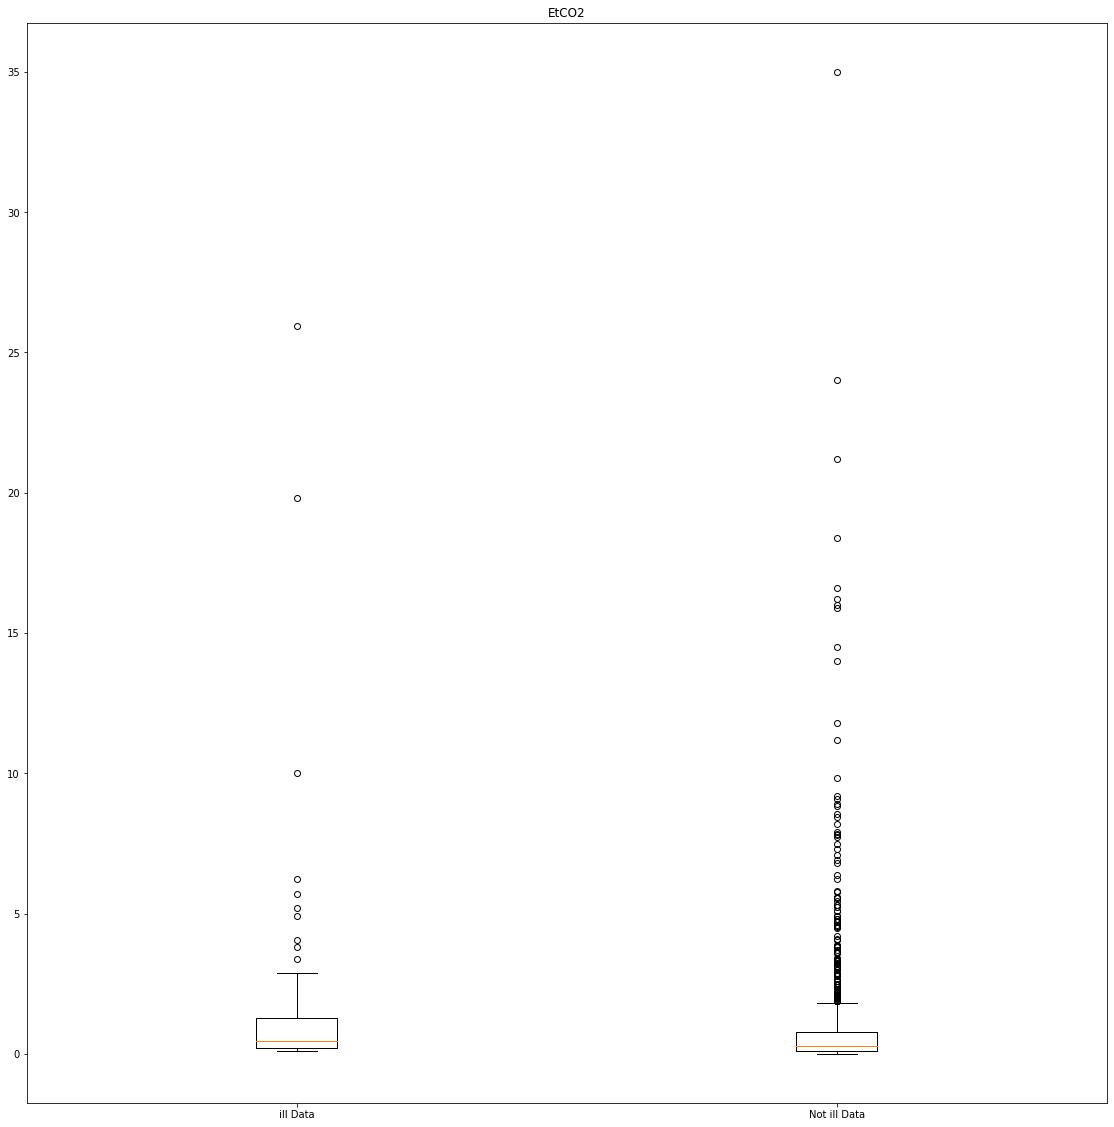

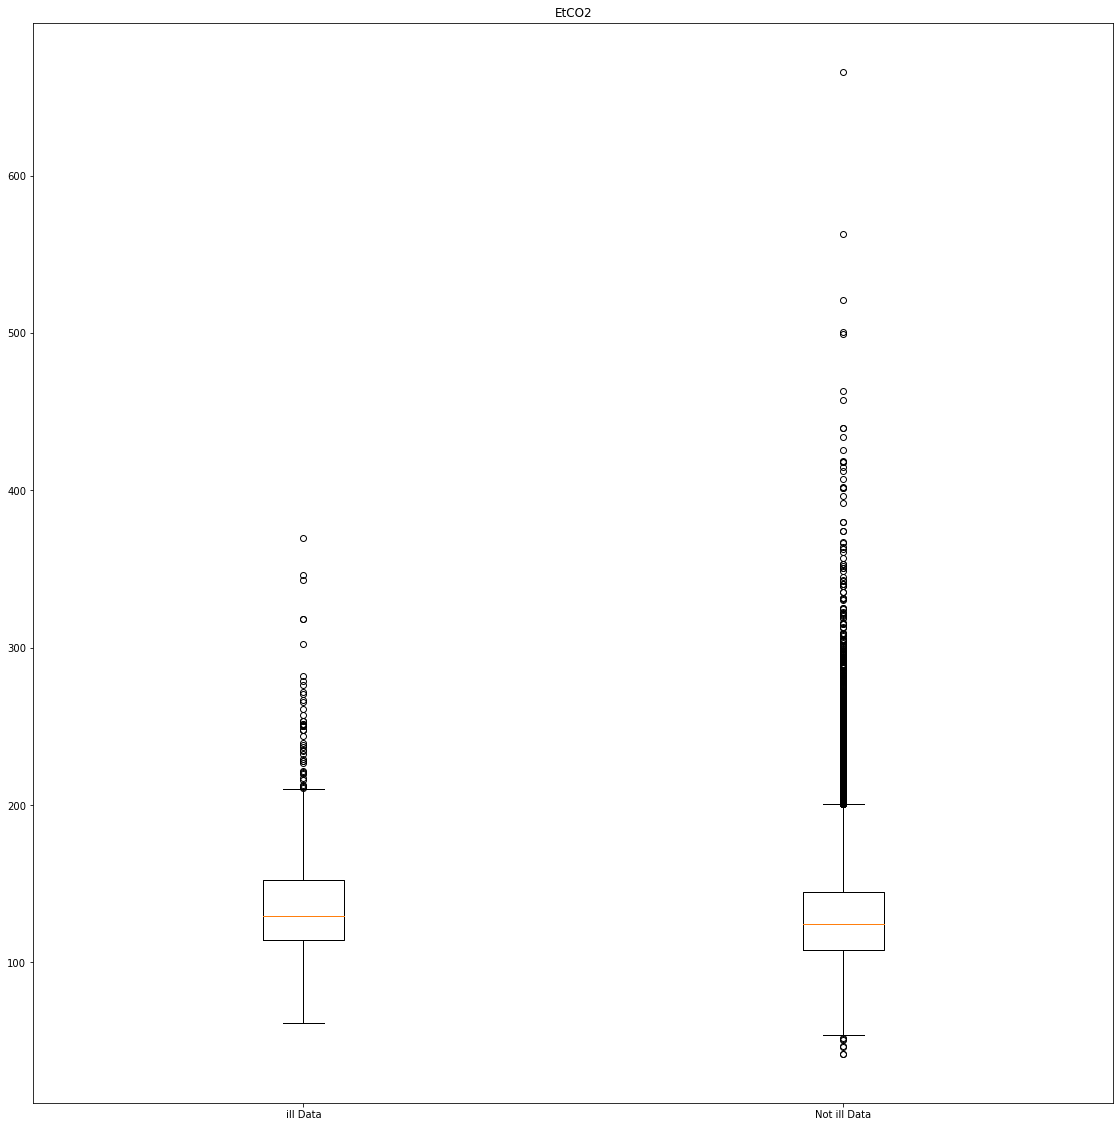

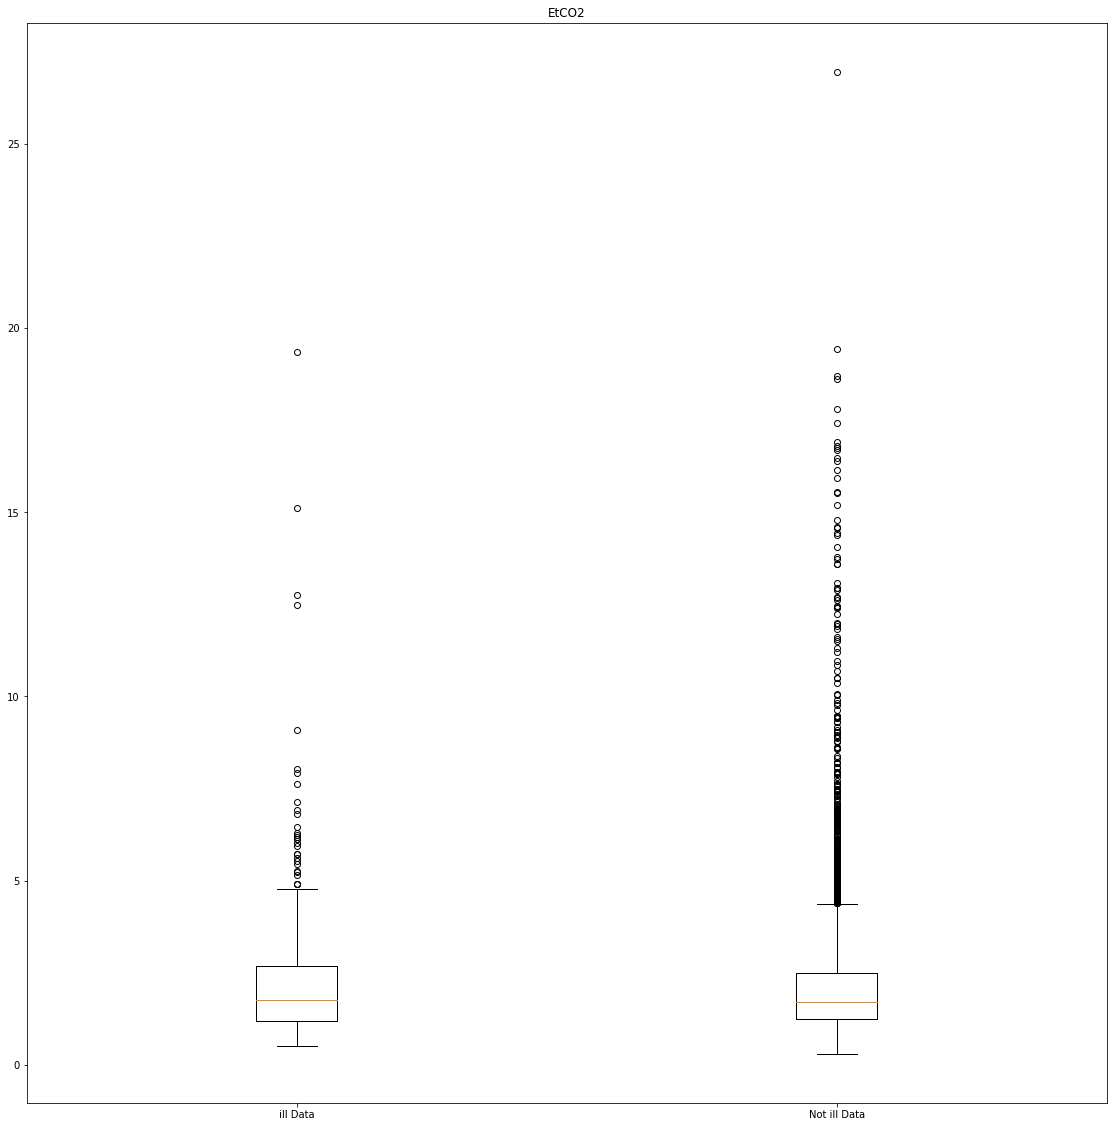

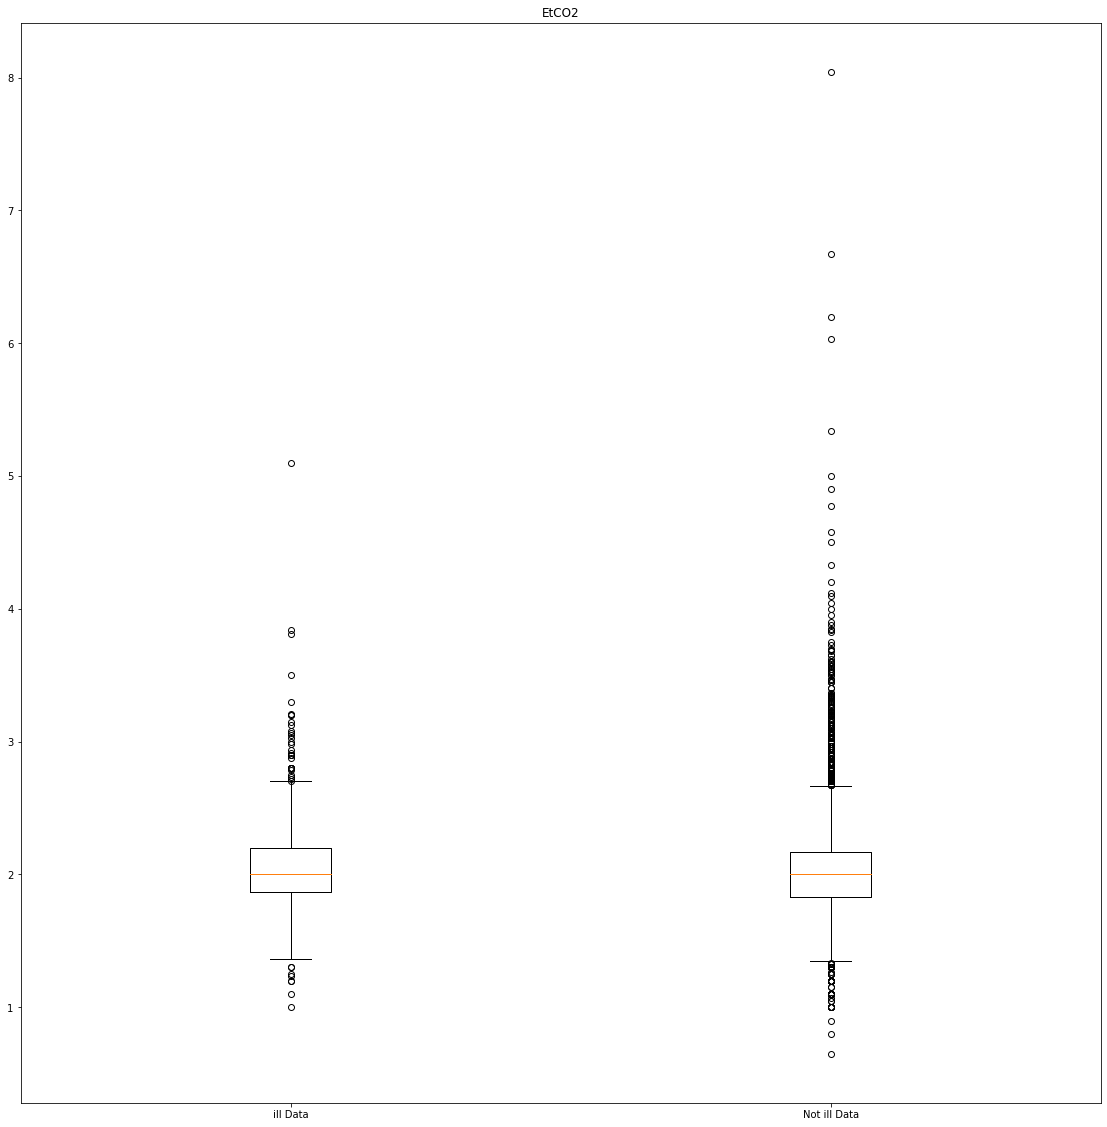

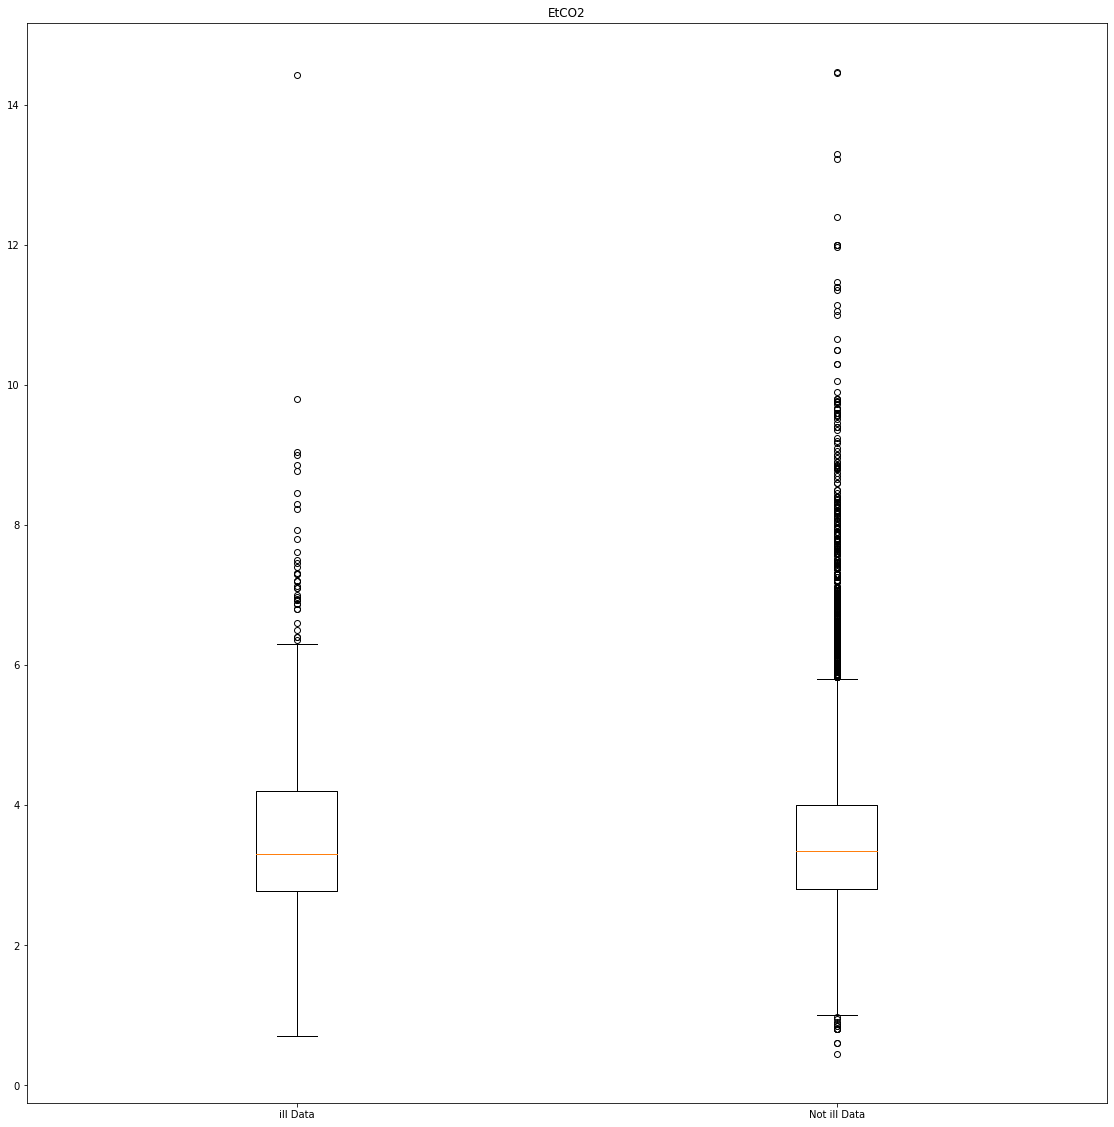

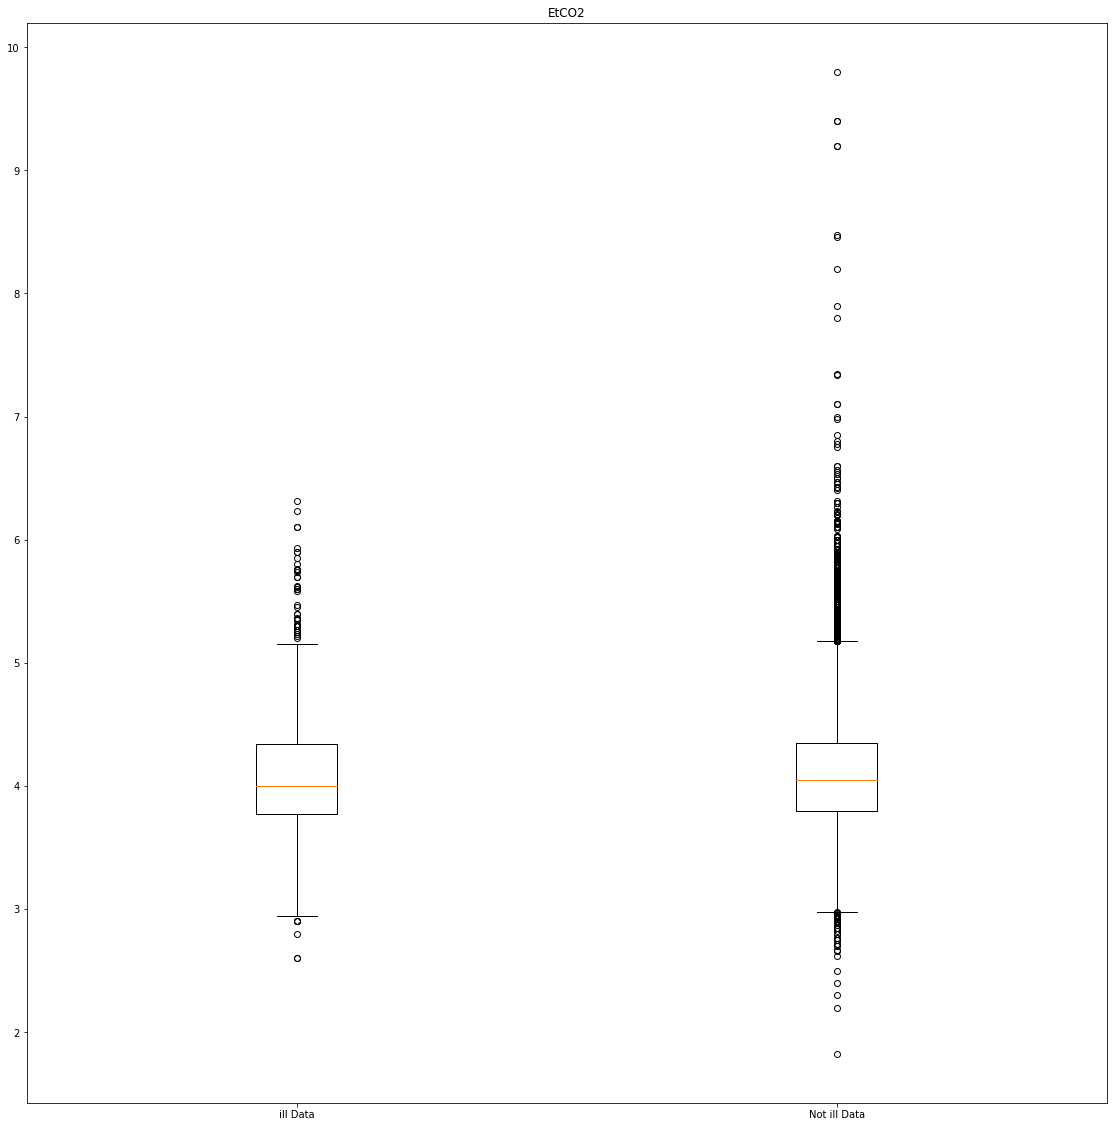

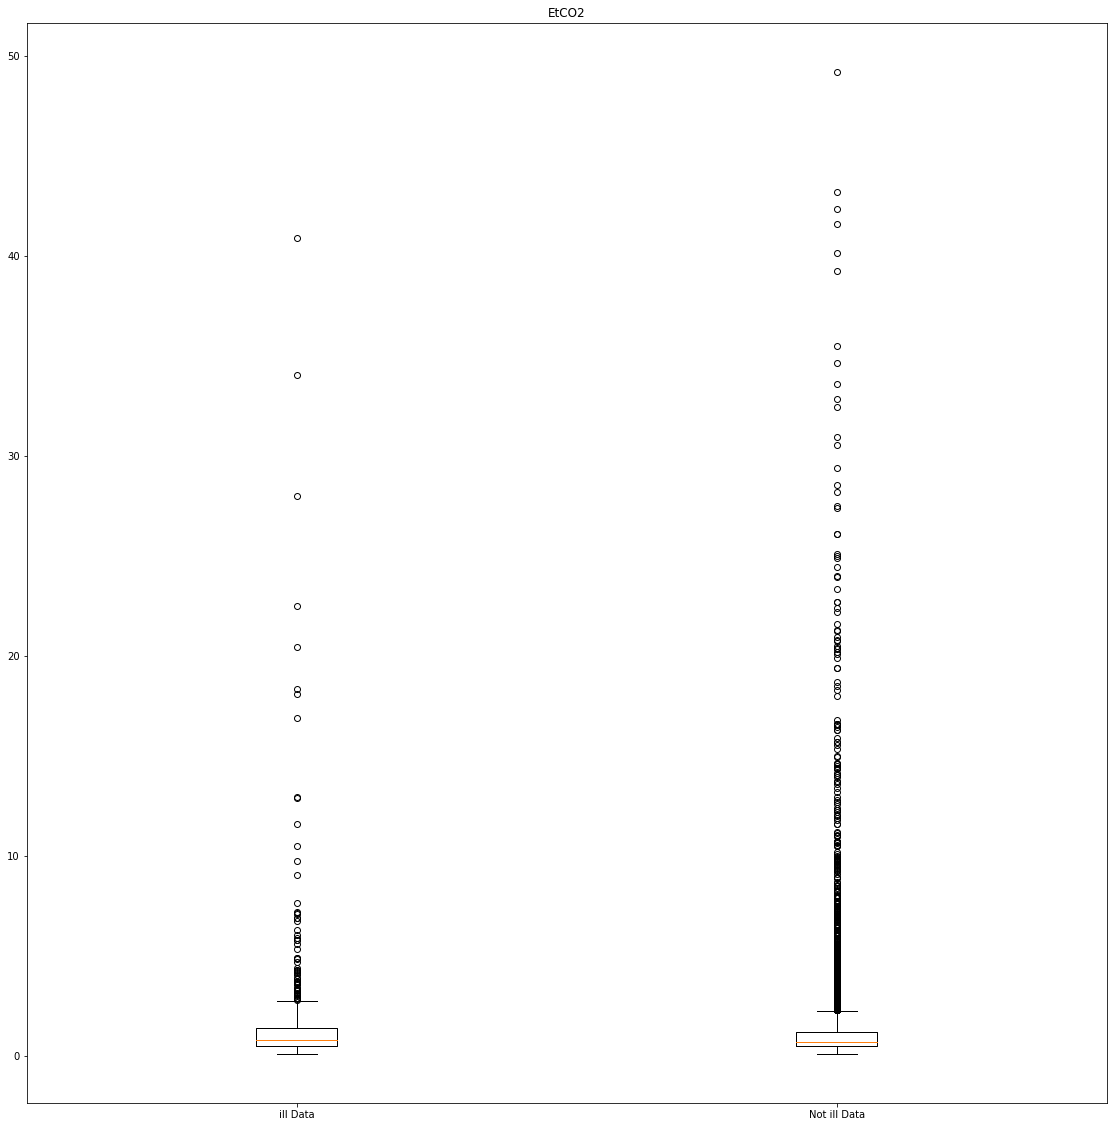

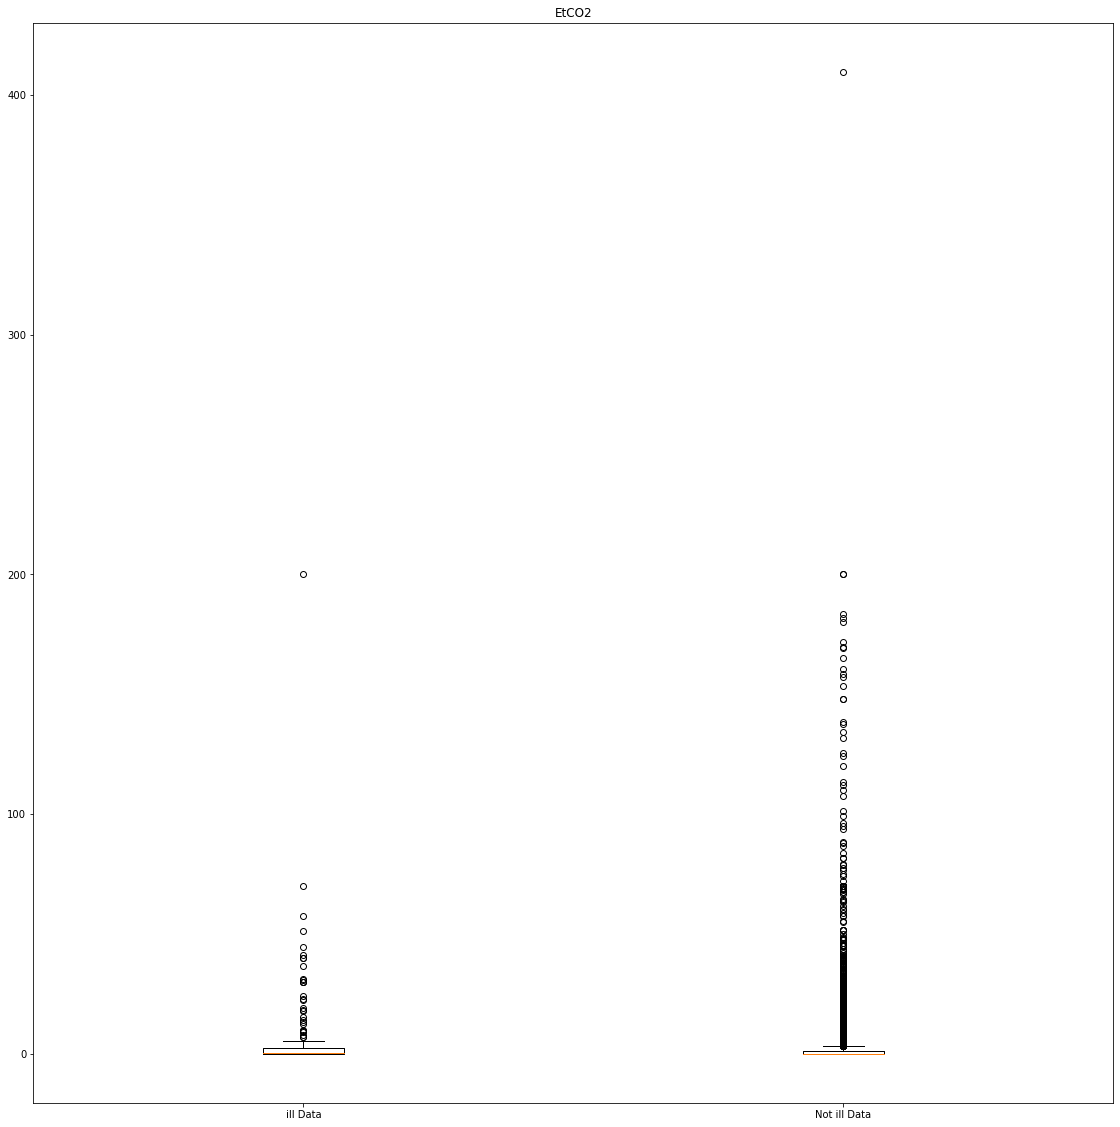

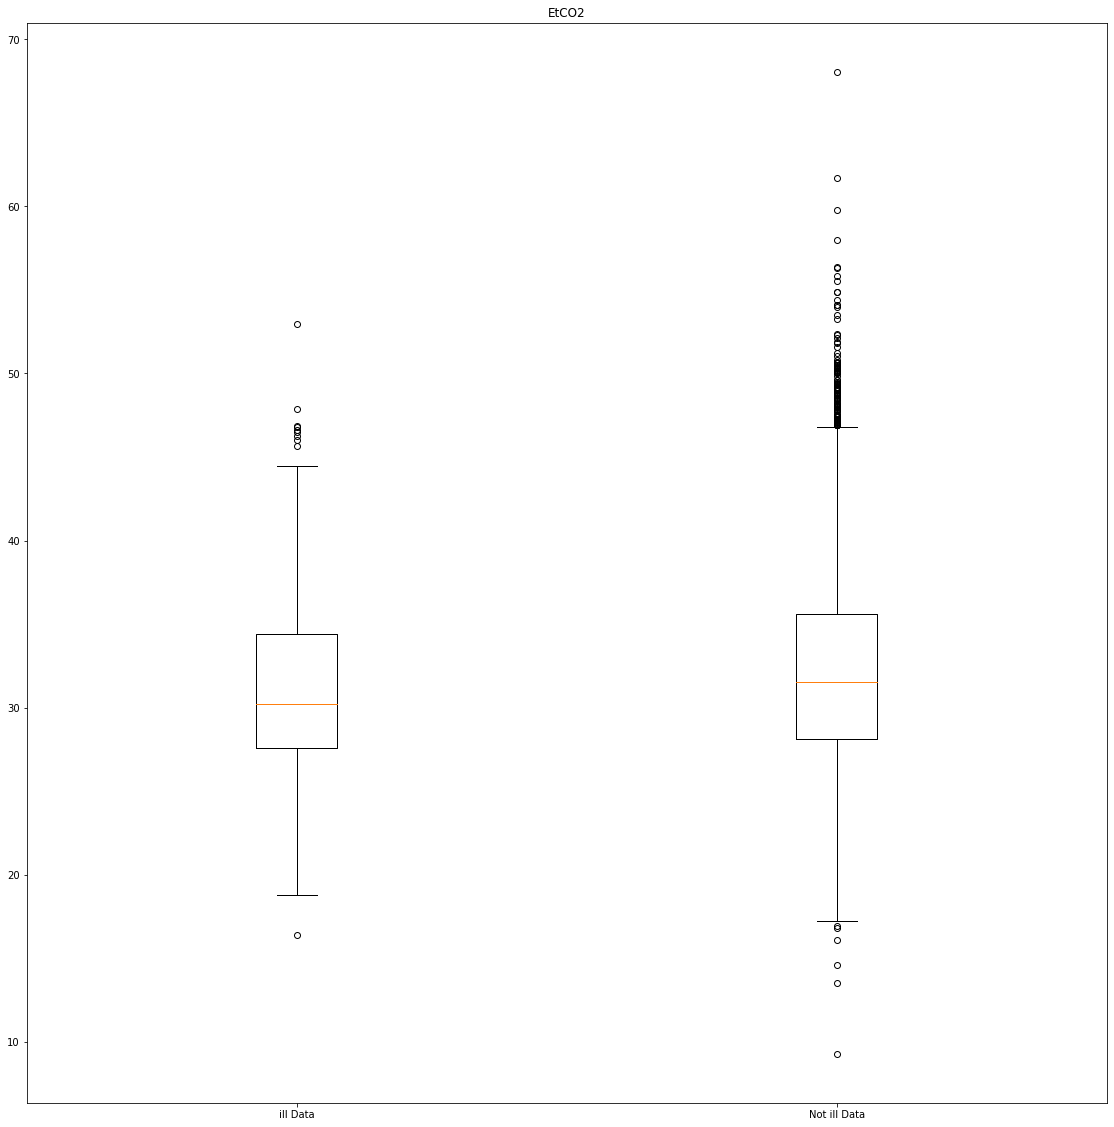

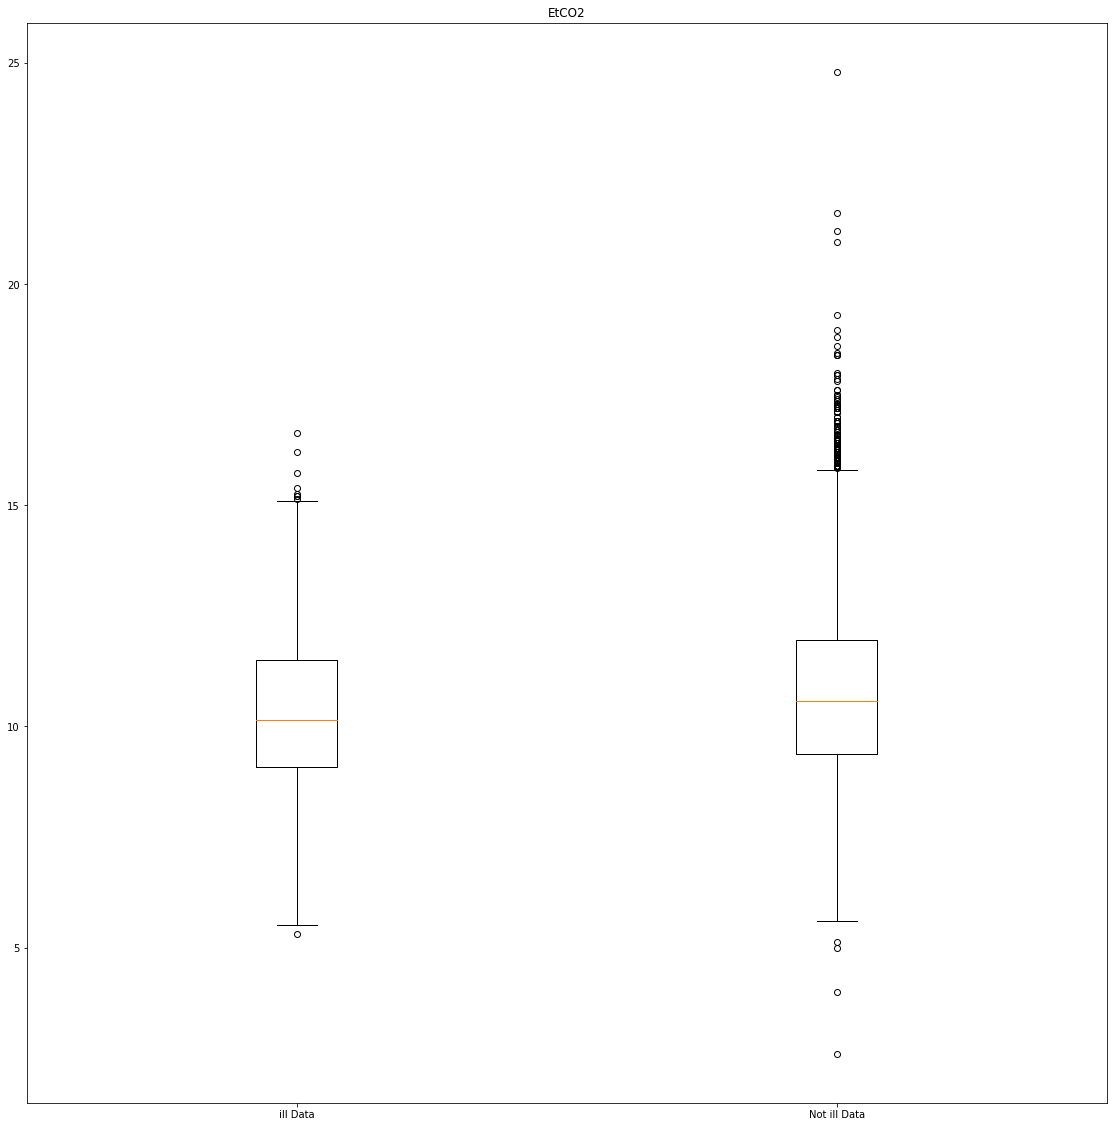

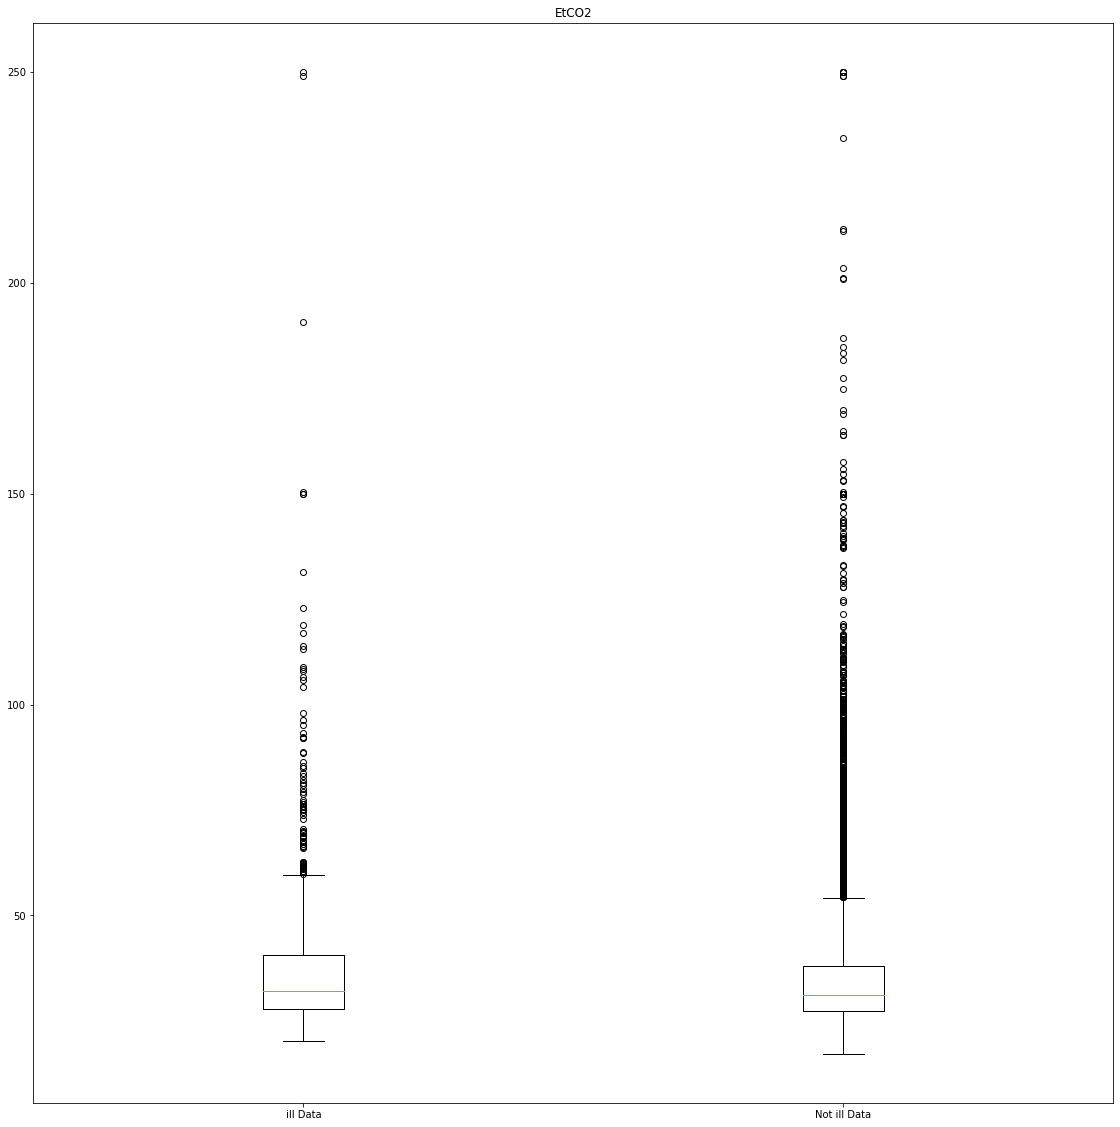

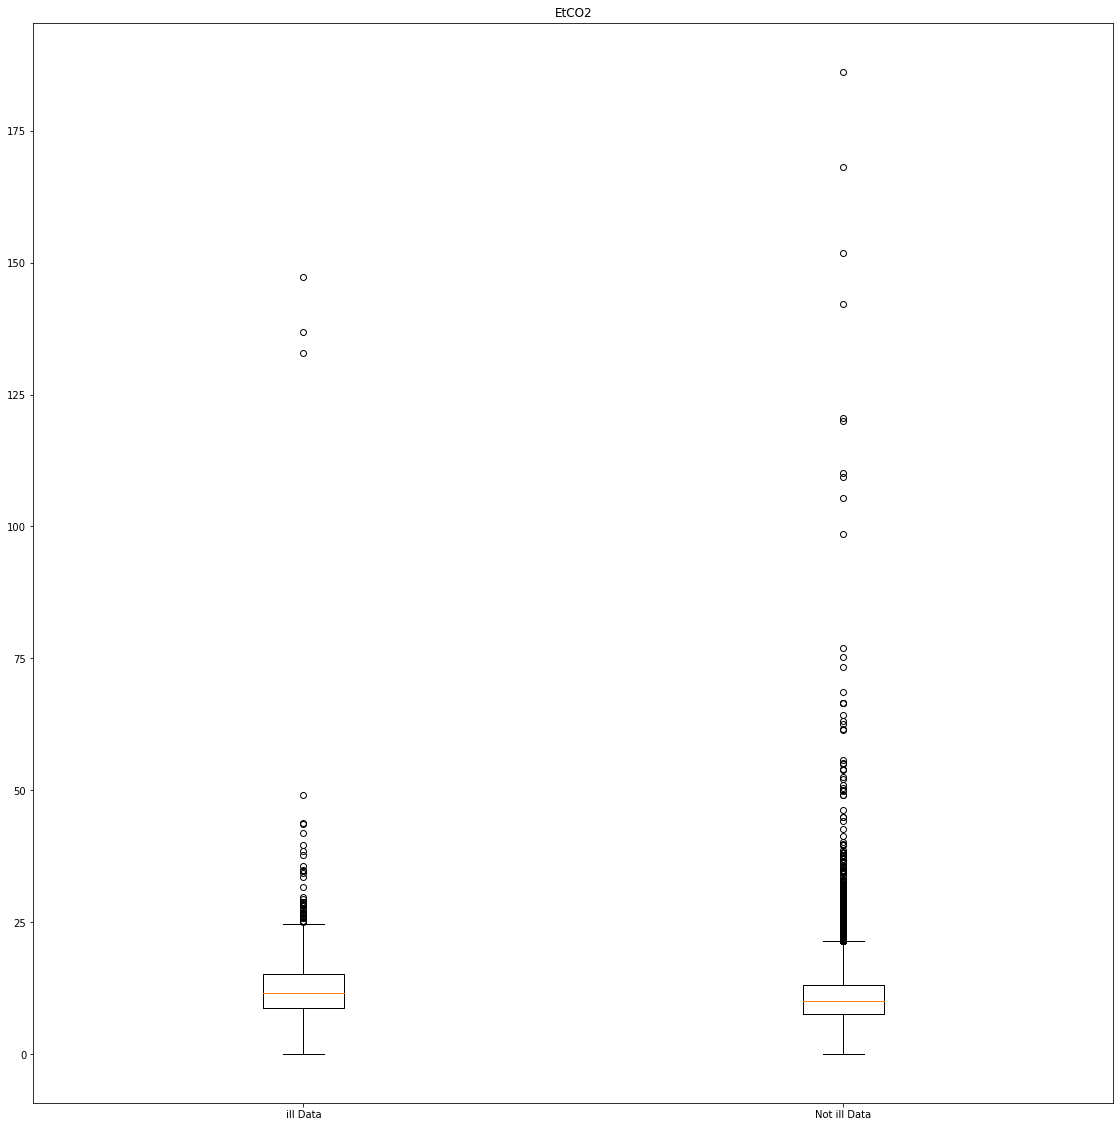

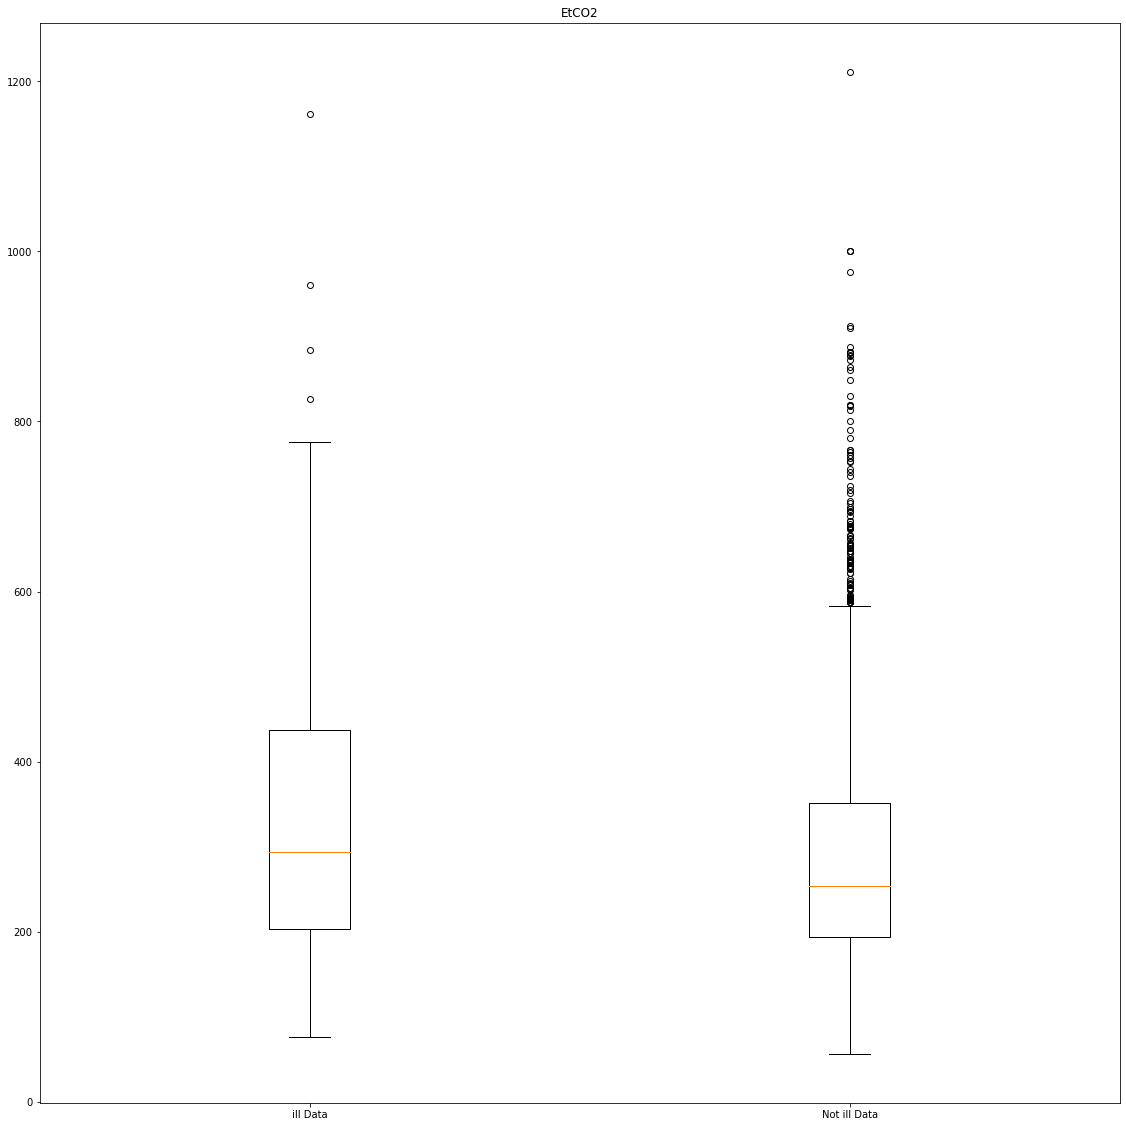

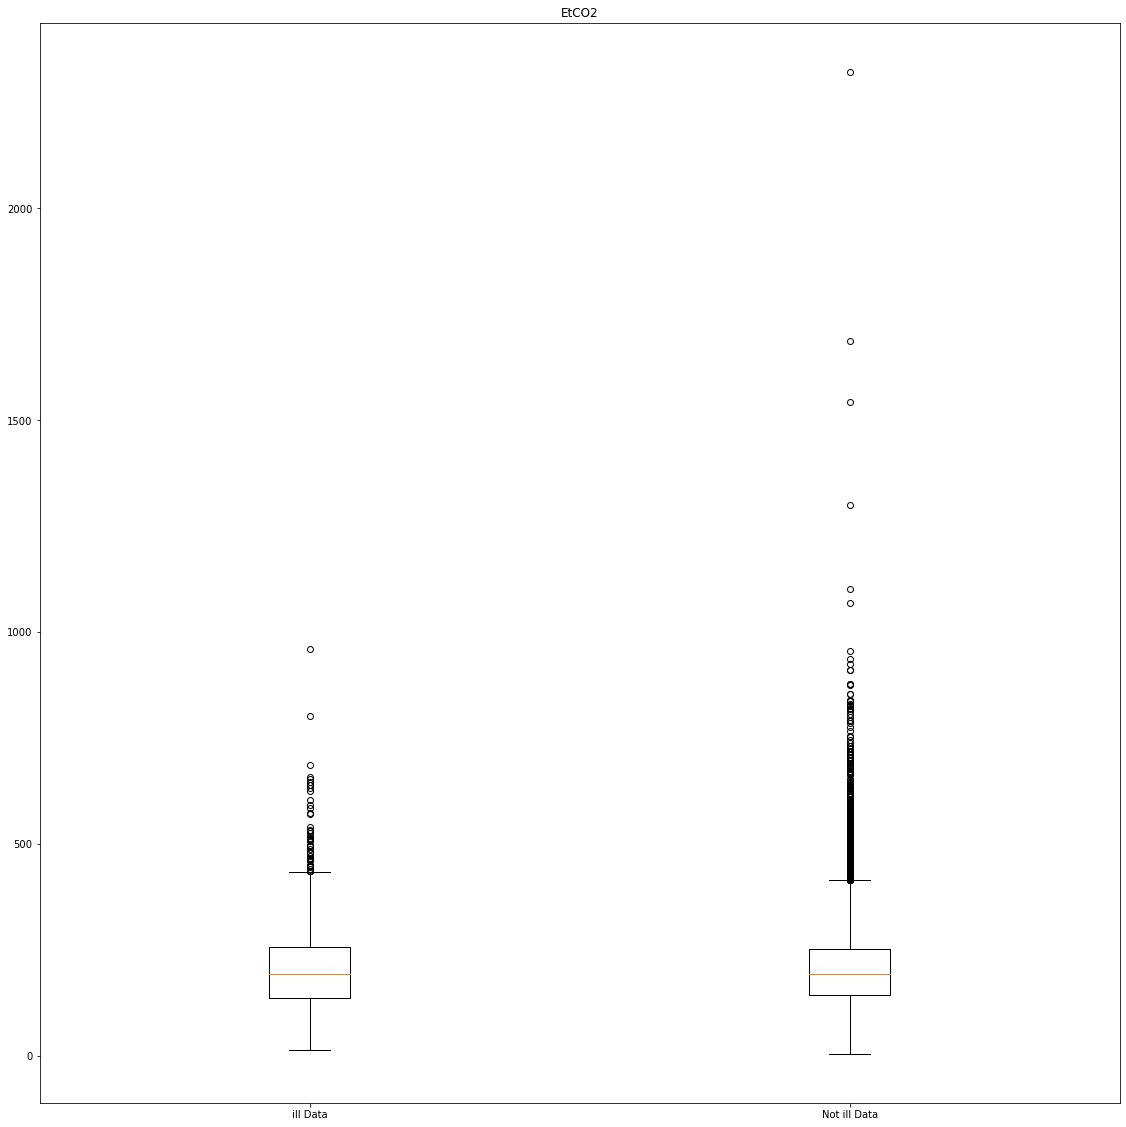

In [35]:
for lab in labs:
    fig = plt.figure(figsize =(15, 15))

    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])

    # Creating plot
    bp = ax.boxplot([np.array(ill_mean[lab].dropna()), np.array(not_ill_mean[lab].dropna())])

    # show plot
    ax.set_xticklabels(['ill Data', 'Not ill Data'])
    ax.get_xaxis().tick_bottom()
    plt.title(vital)
    plt.show()

We compared the distribution of the vital and labaratory features over the ill and not ill patients.
we witnessed two interesting things:

First, we saw that each feature's distribution under the two groups of ill or not ill does not appear to be very different at. Thus, we will need to use further testing to see if there exists a statistical difference.
Second, we can see that the distributions themselves are highly contained with outliers

### hypothesis testing

#### Demographics

In [36]:
# HospAdmTime
HospAdmTime_test_stat, HospAdmTime_p_val = ztest(df[df['SepsisLabel'] == 0]['HospAdmTime'], df[df['SepsisLabel'] == 1]['HospAdmTime'], value=0)
print(f'HospAdmTime - the p-value of the test is {HospAdmTime_p_val:.3}')

# ICULOS
ICULOS_test_stat, ICULOS_p_val = ztest(df[df['SepsisLabel'] == 0]['ICULOS'], df[df['SepsisLabel'] == 1]['ICULOS'], value=0)
print(f'ICULOS - the p-value of the test is {ICULOS_p_val:.3}')

HospAdmTime - the p-value of the test is 5.92e-203
ICULOS - the p-value of the test is 0.0


As we can see from the p-values of the tests, they are both < 0.05 and thus we have sufficient evidence to reject the null hypothesis, meaning that the distributions of the features is significantly different between both classes.

#### Vitals

In [37]:
for vital in vitals:
    test_stat, p_val = ztest(df[df['SepsisLabel'] == 0][vital].dropna(), df[df['SepsisLabel'] == 1][vital].dropna(), value=0)
    print(f'{vital} - the p-value of the test is {p_val:.3}')

HR - the p-value of the test is 0.0
O2Sat - the p-value of the test is 1.05e-31
Temp - the p-value of the test is 1.12e-231
SBP - the p-value of the test is 6.37e-21
MAP - the p-value of the test is 3.06e-05
DBP - the p-value of the test is 7.57e-95
Resp - the p-value of the test is 0.0
EtCO2 - the p-value of the test is 0.0784


The EtCO2 is the only feature for which the p-value > 0.05, thus it is the only feature of the vital features for which the distributions are similar.For all the other features we can reject the null hypothesis, meaning the distributions are significantly different between both classes

#### Labaratory 

In [38]:
count = 0
for lab in labs:
    test_stat, p_val = ztest(df[df['SepsisLabel'] == 0][lab].dropna(), df[df['SepsisLabel'] == 1][lab].dropna(), value=0)
    print(f'{lab} - the p-value of the test is {p_val:.3}')
    if p_val < 0.05:
        count+=1
print()
print("the number of tests we reject is :",count)

BaseExcess - the p-value of the test is 1.63e-13
HCO3 - the p-value of the test is 0.451
FiO2 - the p-value of the test is 0.606
pH - the p-value of the test is 8.19e-18
PaCO2 - the p-value of the test is 0.294
SaO2 - the p-value of the test is 0.000327
AST - the p-value of the test is 0.567
BUN - the p-value of the test is 1.7e-71
Alkalinephos - the p-value of the test is 0.303
Calcium - the p-value of the test is 4.82e-45
Chloride - the p-value of the test is 0.19
Creatinine - the p-value of the test is 9.79e-07
Bilirubin_direct - the p-value of the test is 0.000485
Glucose - the p-value of the test is 0.0222
Lactate - the p-value of the test is 0.0945
Magnesium - the p-value of the test is 6.66e-19
Phosphate - the p-value of the test is 0.185
Potassium - the p-value of the test is 8.34e-07
Bilirubin_total - the p-value of the test is 2.03e-23
TroponinI - the p-value of the test is 0.112
Hct - the p-value of the test is 6.81e-25
Hgb - the p-value of the test is 2.85e-21
PTT - the p-v

Out of all the  laboratory features, we reject 17 of the tests and conclude that the distribution are significantly different between the classes. It is important to notice that the significance levels are different in each test, but in all of them it is < 0.05.



# Feature Engineering

## Feature Selection

In [39]:
updated_df= df.drop(columns=['EtCO2' , 'Temp','Bilirubin_direct', 'Fibrinogen','TroponinI'])

First, we removed the columns from the vital features and the lab features which had the highest amount of missing values from those groups.

In [40]:
updated_df = updated_df.drop(columns=['Hct' , 'HCO3','DBP'])

Second, Based on the correlation testing- we decided to drop one of the features from each pair with correlation larger than a 0.8 threshold  (with the exception of the unit1 and unit2 features).

## Feature Transformation + Handling missing data

In [41]:
def feature_agg(patient_df):
    patient_df = patient_df.drop(columns = ['SepsisLabel']) 
    mean=patient_df.mean().to_numpy()
    mins=patient_df.min().to_numpy()
    maxs=patient_df.max().to_numpy()  
    patient_vector=np.concatenate((mean,mins,maxs), axis=0)
    patient_series=pd.Series(patient_vector).fillna(-1)  
    return patient_series

In [42]:
agg_df = pd.DataFrame()
for id in range(0,20000):
    patient_df = updated_df.loc[updated_df.patient_id==str(id)]
    patient_df = patient_df.drop(columns = ['patient_id']) 
    patient_series=feature_agg(patient_df)
    is_ill=1 if 1 in patient_df['SepsisLabel'].unique() else 0
    patient_series['PatientLabel']=is_ill
    agg_df = agg_df.append(patient_series, ignore_index=True)

In [43]:
aggregated_train=agg_df

In [44]:
agg_df = pd.DataFrame()
for patient_file in os.listdir("./data/test/"):
    patient_df = pd.read_csv(os.path.join("./data/test/",patient_file), sep='|')
    patient_df = patient_df.drop(columns=['EtCO2' , 'Temp','Bilirubin_direct', 'Fibrinogen','TroponinI','Hct', 'HCO3','DBP'])
    if 1 in patient_df['SepsisLabel'].unique():
        first_row_sepsis = patient_df[patient_df['SepsisLabel'] == 1].iloc[0].name
        patient_df = patient_df.iloc[:first_row_sepsis + 1]    
    patient_series=feature_agg(patient_df)
    is_sick=1 if 1 in patient_df['SepsisLabel'].unique() else 0
    patient_series['PatientLabel']=is_sick

    agg_df = agg_df.append(patient_series, ignore_index=True)



We decided to represent each feature (from features that we use) for each patient with 3 values : mean,min and max.
This transformation allows us to reduce the data for each patient to one vector. In addition, it minimizes the missing data problem because for each patient we now use just this 3 matrics (for each feature). 

Columns in whom all the values are missing for some patient we put the value -1 in them and in this way we are handling with the missing data issue.




In [45]:
aggregated_test=agg_df

## Additional Feature Selection

In [46]:
X = aggregated_train.iloc[:,0:-1]
Y = aggregated_train.iloc[:,-1]
# Create and fit selector
selector = SelectKBest(f_classif, k=20)
selector.fit(X, Y)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
X_new = X.iloc[:,cols]

For better feature selection we use SelectKBest function of sklearn, that select features according to the k highest scores. The score that we sort according to is ANOVA F-value. The function f_classif calculate the F-statistic and the p value for each feature and than the SelectKBest function returns us k (in our case 20) features with highest score.


In [47]:
X_test = aggregated_test.iloc[:,cols]
Y_test = aggregated_test.iloc[:,-1]

# Prediction

In order to evaluate the results of the model we will split the train set into "train" set and "validation" set.
The matrics that we will use for evaluation of the model are: F1, accuracy, ROC-AUC.
The accuracy score could be not informative because of the imbalance of the data.

In [48]:
X_train, X_val, Y_train, Y_val = train_test_split(X_new,Y,train_size=0.8, stratify=Y,random_state=42)

For the submission, we decided to include two aggregated models:

1) KNN model as baseline

2) Random Forest classifier model as the main submitted model

## KNN model

In [49]:
num_neighbors_list =[5,11,16,21,26,31,36,41,46,51]
f1_score_list = []
accuracy_list = []
roc_auc_list = []
for k in num_neighbors_list:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, Y_train)
    knn_pred = neigh.predict(X_val)
    print(f'Validation set scores of the model with k = {k} are:')
    f1 = f1_score(Y_val, knn_pred, average='binary')
    f1_score_list.append(f1)
    print(f"F1 score {f1}")
    acc = accuracy_score(Y_val, knn_pred)
    accuracy_list.append(acc)
    print(f"Accuracy score {acc}")
    roc_auc = roc_auc_score(Y_val, neigh.predict_proba(X_val)[:, 1])
    roc_auc_list.append(roc_auc)
    print(f"ROC-AUC score {roc_auc}")
    print()

Validation set scores of the model with k = 5 are:
F1 score 0.5906040268456375
Accuracy score 0.95425
ROC-AUC score 0.8043812641944043

Validation set scores of the model with k = 11 are:
F1 score 0.5852534562211982
Accuracy score 0.955
ROC-AUC score 0.8356552978341323

Validation set scores of the model with k = 16 are:
F1 score 0.5613207547169812
Accuracy score 0.9535
ROC-AUC score 0.8338153132727009

Validation set scores of the model with k = 21 are:
F1 score 0.5476190476190477
Accuracy score 0.9525
ROC-AUC score 0.8389378949359784

Validation set scores of the model with k = 26 are:
F1 score 0.5410628019323671
Accuracy score 0.9525
ROC-AUC score 0.8431397713304642

Validation set scores of the model with k = 31 are:
F1 score 0.5493975903614458
Accuracy score 0.95325
ROC-AUC score 0.8422613700208478

Validation set scores of the model with k = 36 are:
F1 score 0.5423728813559322
Accuracy score 0.95275
ROC-AUC score 0.8479743058110429

Validation set scores of the model with k = 41 

We used grid search for choosing the best number of neighbors.
As we can see we got the best results for k = 5.
Now we will run the algorithm with k = 5 trained on all the original train set and we will see the model results on the test set.

In [50]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_new, Y)
knn_pred = neigh.predict(X_test)
print(f'Test set scores of the model with k = 5 are:')
f1 = f1_score(Y_test, knn_pred, average='binary')
print(f"F1 score {f1}")
acc = accuracy_score(Y_test, knn_pred)
print(f"Accuracy score {acc}")
roc_auc = roc_auc_score(Y_test, neigh.predict_proba(X_test)[:, 1])
print(f"ROC-AUC score {roc_auc}")


Test set scores of the model with k = 5 are:
F1 score 0.6104347826086955
Accuracy score 0.9552
ROC-AUC score 0.79715057122814


Feature importance is not defined for the KNN Classification algorithm.

### KNN Analysis

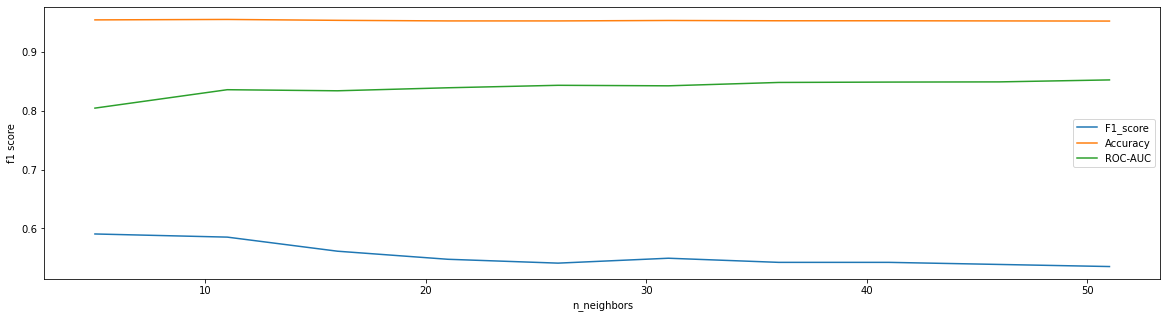

<Figure size 1080x1080 with 0 Axes>

In [51]:
x = num_neighbors_list
plt.plot(x, f1_score_list, label = "F1_score")
plt.plot(x, accuracy_list, label = "Accuracy")
plt.plot(x, roc_auc_list, label = "ROC-AUC")
plt.legend()

plt.xlabel('n_neighbors')
plt.ylabel('f1 score')
plt.figure(figsize=(15, 15))

plt.show()

When we look at this plot we see different trends for the different metrics.
For the F1_score as the number of neighbors grows the f1 score goes lower in general.
For the ROC-AUC score it grows along with the number of neighbors.
For the Accuracy score it remains in same area even while the number of neighbors changes.

## Random Forest Classifier Model

In [52]:

n_estimators_list = [100,200,300]
max_depth_list = [3,5,7,9,11, 15, 21]
f1_score_list = []
accuracy_list = []
roc_auc_list = []
for n_estimator in n_estimators_list:
    for depth in max_depth_list: 
        rfc=RandomForestClassifier(n_estimators = n_estimator, max_depth = depth,random_state = 42)
        rfc.fit(X_train, Y_train)
        rfc_pred = rfc.predict(X_val)
        print(f'Validation set scores of the model with n estimators = {n_estimator} and max depth = {depth} are:')
        f1 = f1_score(Y_val, rfc_pred, average='binary')
        f1_score_list.append(f1)
        print(f"F1 score {f1}")
        acc = accuracy_score(Y_val, rfc_pred)
        accuracy_list.append(acc)
        print(f"Accuracy score {acc}")
        roc_auc = roc_auc_score(Y_val, rfc.predict_proba(X_val)[:, 1])
        roc_auc_list.append(roc_auc)
        print(f"ROC-AUC score {roc_auc}")
        print()

Validation set scores of the model with n estimators = 100 and max depth = 3 are:
F1 score 0.639821029082774
Accuracy score 0.95975
ROC-AUC score 0.8682882867466923

Validation set scores of the model with n estimators = 100 and max depth = 5 are:
F1 score 0.6908315565031983
Accuracy score 0.96375
ROC-AUC score 0.8770014763606426

Validation set scores of the model with n estimators = 100 and max depth = 7 are:
F1 score 0.6980728051391863
Accuracy score 0.96475
ROC-AUC score 0.8889573357441837

Validation set scores of the model with n estimators = 100 and max depth = 9 are:
F1 score 0.6993603411513859
Accuracy score 0.96475
ROC-AUC score 0.8880703785776554

Validation set scores of the model with n estimators = 100 and max depth = 11 are:
F1 score 0.7048832271762208
Accuracy score 0.96525
ROC-AUC score 0.8912493547457911

Validation set scores of the model with n estimators = 100 and max depth = 15 are:
F1 score 0.7148936170212766
Accuracy score 0.9665
ROC-AUC score 0.8935228360574232

We used grid search for choosing the number of trees and the maximum depth of the trees.
We saw that the number of trees didn't change much, but in depth we saw in general that up to 15 the F1 score kept climbing, and than the F1 results started to decrese.
The ROC-AUC metric had the same trend as the F1 score, while the accuracy results remained largly unchanged.

In [53]:
# train the same exact model, but on the entire training data available - save the statedict
rfc=RandomForestClassifier(n_estimators = 100, max_depth = 15,random_state = 42)
rfc.fit(X_new, Y)
pickle.dump(rfc[0], open('RF_Classifier.pkl', 'wb'))
rfc_pred = rfc.predict(X_test)
print(f'Test set scores of the model is:')
f1 = f1_score(Y_test, rfc_pred, average='binary')
print(f"F1 score {f1}")
acc = accuracy_score(Y_test, rfc_pred)
print(f"Accuracy score {acc}")
roc_auc = roc_auc_score(Y_test, rfc.predict_proba(X_test)[:, 1])
print(f"ROC-AUC score {roc_auc}")

Test set scores of the model is:
F1 score 0.6769731489015459
Accuracy score 0.9603
ROC-AUC score 0.882443809641245


### Random Forest Analysis

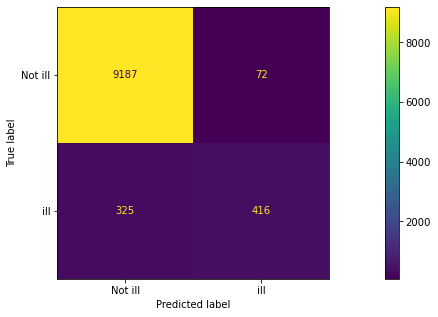

In [54]:
cm = confusion_matrix(Y_test, rfc_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not ill', 'ill'])
disp.plot()
plt.show()


The reason that we see a very good results on not ill class is because of the imbalance that we saw in our data.


In [55]:
importances = rfc[0].feature_importances_
importance_per_feature = importances
D=pd.DataFrame.from_dict({'Feature':cols,'Importance':importance_per_feature})
display(D.sort_values(by='Importance',ascending=False).head(5))

,Feature,Importance
19,95,0.349705
6,31,0.295208
1,2,0.037129
18,86,0.036863
15,66,0.033063


We see that we have 2 features with very high importance(relativly to other features).

Feature number 95 is the max of the ICULOS feature. This feature is from the group of demographic features so it's max value is the same value that the patienth has.
It supports our exploratory data analysis results, where we saw big differnces in ICULOS of ill patients and not ill pantients.

Feature number 31 is the minimum value of AST which is one of the labaratory results.

# Summary and Discussion

As we can see, the Random Forest model outperformed the KNN model in all scoring parameters, and most importantly, in the F1 score, which is our parameter of interest. When considering the differences between the two classification models, we note that Random Forest is an ensemble learning model, while the KNN model didn't really learned and just calculate the distances. A fundemental advantage of ensemble models is the higher performances and robustness.

Furthermore, the Random Forest model is not parametrc and does not make any assumptions regarding the data nor it's distribution. In the Explanatory data analysis section we saw that the data does include outliers, and there are columns which are correlated (in addition to the clear ones we removed).

In general, both of our models which are simple machine learning models and not neural networks met the standards of this task(F1 > 0.5), even that we have a lot of data.

The initial exploratory data analysis helped us to get intuition about our data and better understanding of some of the results.

During this task of Early Prediction of Sepsis from Clinical Data  we practiced most of the real world pipeline on data. Beginning with data exploration and cleaning to feature selection, handling of missing data, model construction and evaluation. 
